In [1]:
import os

from bs4 import BeautifulSoup
import requests
import re
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.reset_orig()
# from collections import defaultdict


In [2]:
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['font.size'] = 12

## Scraping info from one listing

In [3]:
ex_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html"

In [4]:
ex_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html"

In [5]:
r = requests.get(ex_page)

In [6]:
soup = BeautifulSoup(r.text, "lxml")

In [3]:
with open("Tests/4874296_de.html") as f:
    soup = BeautifulSoup(f.read(), "lxml")

In [4]:
panel_bodies = soup.find_all("div", "panel-body")

In [200]:
with open("debug.html", "w") as f:
    f.write(str(soup))

In [5]:
def get_coords(soup):
    gmap_text = soup.find("div", onclick=re.compile(r"loadGMap.*"))['onclick']
    return [float(x) for x in re.findall(r"[0-9\.]+", gmap_text)[0:2]]

In [6]:
get_coords(soup)

[53.570961, 9.956365]

In [7]:
panel_info = panel_bodies[0]

In [8]:
price_translation = {
    'miete': "base_rent",
    "nebenkosten": "utilities",
    "sonstige_kosten": "miscellaneous_costs",
    "kaution": "deposit",
    "abstandszahlung": "existing_equipment_fees"
}

def get_price_dict(panel):
    raw_prices = panel.find('div', 'col-xs-12 col-sm-5')
    price_list = [x.text.lower().strip().strip(":€").replace(" ", "_").replace("n.a.", "0")
                  for x in raw_prices.find_all('td') 
                  if not x.text.upper().strip().startswith('SCHUFA')]
    price_dict = {}
    for name, price in zip(price_list[:-1:2], price_list[1::2]):
        price_dict[name] = int(price)
    for k, v in price_translation.items():
        if k in price_dict.keys():
            price_dict[v] = price_dict[k]
            price_dict.pop(k, None)
    return price_dict

In [9]:
get_price_dict(panel_info)

{'base_rent': 410, 'deposit': 1300, 'miscellaneous_costs': 25, 'utilities': 80}

In [10]:
def get_address_dict(panel):
    raw_address = panel.find('div', 'col-xs-12 col-sm-4').find('a').text
    address_parts = [x.strip() for x in  raw_address.split('\n') if x.strip() != '']
    house_line =  re.sub(r'  +', ' ', address_parts[0])
    house_parts = house_line.split()
    house_number = -1
    for hp in house_parts:
        if hp.isdigit():
            house_number = hp
            house_line = house_line.replace(house_number, "").strip()
            break
    street = house_line

    postcode_line = re.sub(r'  +', ' ', address_parts[1])
    postcode_line = re.sub(r'Germany', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'Hamburg', '', postcode_line, flags=re.I | re.UNICODE)
    postcode_line = re.sub(r'[\n ]+', ' ', postcode_line)
    postcode_pattern = re.compile(r'(?P<postcode>2[\d]+) (?P<region>.*)', flags=re.I | re.UNICODE)
    postcode_match = postcode_pattern.search(postcode_line)
    postcode = postcode_match['postcode']
    region = postcode_match['region']    
    return {'street': street, 'house_number': int(house_number), 'region': postcode_match['region'], 'postcode': int(postcode_match['postcode'])}

In [11]:
get_address_dict(panel_info)

{'house_number': -1,
 'postcode': 20259,
 'region': 'Eimsbüttel',
 'street': 'Osterstraße'}

In [12]:
def get_availability_dict(panel):
    availability = panel.find('div', 'col-xs-12 col-sm-3')
    availability_values = [x.text.strip() for x in availability.find_all('b')]
    return dict(zip(['start_date', 'ad_placed'], availability_values))

In [13]:
get_availability_dict(panel_info)

{'ad_placed': 'Online: 13 Stunden', 'start_date': '27.04.2017'}

In [14]:
panel_details = panel_bodies[1]

In [15]:
def get_details_dict(panel):
    raw_details, searching_details = panel.find_all('div', 'col-sm-6')
    space_pattern = re.compile(r'[\n ]+')
    details_parts = [space_pattern.sub(' ', x.text.strip()) for x in raw_details.find_all('li')]
    details_text = " ".join(details_parts)
    
    room_area = 0
    area_pattern = re.compile(r'[0-9]+')
    area_match = area_pattern.match(details_parts[0].split()[0])
    if area_match:
        room_area = int(area_match[0])

    total_area = 0
    size_pattern = re.compile(r'Wohnungsgröße: ([0-9]+)', flags=re.I)
    size_match = size_pattern.search(details_parts[1])
    if size_match:
        total_area = int(size_match[1])

    total_num_persons = 0
    np_pattern = re.compile(r'([0-9]+)er WG')
    num_persons_match = np_pattern.search(details_text)
    if num_persons_match:
        total_num_persons = int(num_persons_match[1])

    num_females, num_males = 0, 0
    male_female_pattern = re.compile(r'([0-9]+) Frau(?:en)? und ([0-9]+) M[aä]nn',  flags=re.I|re.U)
    genders_match = male_female_pattern.search(details_text)
    if genders_match:
        num_females, num_males = int(genders_match[1]), int(genders_match[2])

    workers_pattern = re.compile(r'Berufstätigen-WG', flags=re.I | re.U)
    students_pattern = re.compile(r'Studenten-WG', flags=re.I)
    workers_ok, students_ok = False, False
    workers_ok = not workers_pattern.search(details_text)
    students_ok = not students_pattern.search(details_text)
    
    languages = []
    for lang_img in raw_details.find_all('img'):
        languages.append(lang_img['title'].lower())
    
    current_min_age, current_max_age = -1, -1
    current_age_pattern = re.compile(r"Bewohneralter: (\d+) bis (\d+) Jahre", flags=re.I | re.U)
    current_age_match = current_age_pattern.search(details_text)
    if current_age_match:
        current_min_age, current_max_age = int(current_age_match[1]), int(current_age_match[2])
    
    desired_min_age, desired_max_age = -1, -1
    desired_age_pattern = re.compile(r"zwischen (\d+) und (\d+) Jahren", flags=re.I | re.U)
    desired_age_match = desired_age_pattern.search("".join(searching_details.text))
    if desired_age_match:
        desired_min_age, desired_max_age = int(desired_age_match[1]), int(desired_age_match[2])
    
    return {'room_area': room_area, 'total_area': total_area, 
            'num_males_current': num_males, 'num_females_current': num_females, 
            'total_occupancy': total_num_persons,
            'workers_ok': workers_ok, 'students_ok': students_ok,
            "languages": languages,
            "current_min_age": current_min_age, "current_max_age": current_max_age,
            "desired_min_age": desired_min_age, "desired_max_age": desired_max_age}

In [16]:
get_details_dict(panel_details)

{'current_max_age': 26,
 'current_min_age': 24,
 'desired_max_age': 30,
 'desired_min_age': 18,
 'languages': ['deutsch', 'englisch'],
 'num_females_current': 0,
 'num_males_current': 2,
 'room_area': 12,
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'workers_ok': False}

In [17]:
panel_features = panel_bodies[2]

In [18]:
f = re.sub(r' {2,}', '', panel_features.text)
[x.replace('\n', ' ') for x in re.split(r'\n{2,}', f) if x]

['Angaben zum Objekt',
 'Altbau',
 'Dusche',
 'Flatrate',
 'DSL, Flatrate, WLAN26-50 Mbit/s',
 'Dielen',
 'schlechte Parkmöglichkeiten',
 '1 Minute zu Fuß entfernt',
 'Waschmaschine, Spülmaschine, Balkon, Keller']

In [19]:
def get_features_dict(panel):
    features_dict = {}
    f = re.sub(r' {2,}', '', panel.text)
    flist = [x.replace('\n', ' ').lower() for x in re.split(r'\n{2,}', f) if x]

    # Now pick out certain features
    def _find_keyword(keyword):
        return any(keyword.lower() in x for x in flist)
    
    if _find_keyword('altbau'):
        features_dict['building'] = "old"
    if _find_keyword('neubau'): 
        features_dict['building'] = "new"
    
    features_dict['balcony'] = _find_keyword('balkon')
    features_dict['washing_machine'] = _find_keyword('waschmaschine')
    features_dict['dishwasher'] = _find_keyword('spülmaschine')
    features_dict['cellar'] = _find_keyword('keller')
    features_dict['garden'] = _find_keyword('garten')
    
    features_dict['transport_distance'] = -1
    for x in flist:
        match = re.search(r'([0-9]+) minute(n)? zu fuß', x, flags=re.I | re.U)
        if match:
            features_dict['transport_distance'] = int(match[1])
            break
    
    return features_dict

get_features_dict(panel_features)

{'balcony': True,
 'building': 'old',
 'cellar': True,
 'dishwasher': True,
 'garden': False,
 'transport_distance': 1,
 'washing_machine': True}

In [20]:
def check_ad_useful(soup):
    return not("der Inserent hat bereits genug Anfragen erhalten" in soup.text or "Anzeige nicht vorhanden" in soup.text)

In [21]:
def extract_ad_info_from_soup(ad_soup):
    panels = ad_soup.find_all("div", "panel-body")
    try:
        info_panel = panels[0]

        ad_dict = dict()
        ad_dict['latitude'], ad_dict['longitude'] = get_coords(ad_soup)
        
#         ad_dict = {'title': ad_soup.title.text}
        ad_dict.update(get_price_dict(info_panel))
        ad_dict.update(get_address_dict(info_panel))

        details_panel = panels[1]
        ad_dict.update(get_details_dict(details_panel))
        
        features_panel = panels[2]
        ad_dict.update(get_features_dict(features_panel))
    except IndexError:
        print("Cannot parse page")
        with open("debug.html", "w") as f:
            f.write(ad_soup.get_text())
        return None
    
    return ad_dict

In [22]:
extract_ad_info_from_soup(soup)

{'balcony': True,
 'base_rent': 410,
 'building': 'old',
 'cellar': True,
 'current_max_age': 26,
 'current_min_age': 24,
 'deposit': 1300,
 'desired_max_age': 30,
 'desired_min_age': 18,
 'dishwasher': True,
 'garden': False,
 'house_number': -1,
 'languages': ['deutsch', 'englisch'],
 'latitude': 53.570961,
 'longitude': 9.956365,
 'miscellaneous_costs': 25,
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20259,
 'region': 'Eimsbüttel',
 'room_area': 12,
 'street': 'Osterstraße',
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'transport_distance': 1,
 'utilities': 80,
 'washing_machine': True,
 'workers_ok': False}

In [23]:
def generate_cache_filename(url):
    return os.path.join("_cache", os.path.basename(url))    

In [24]:
def extract_ad_info(url, read_cache=True, save_cache=True):
    cache_filename = generate_cache_filename(url)
    cache_dir = os.path.dirname(cache_filename)
    
    page_contents = None
    
    if read_cache and os.path.isfile(cache_filename):
        print("Reading from cache", cache_filename)
        with open(cache_filename) as f:
            page_contents = f.read()
    else:    
        r = requests.get(url)
        if r.status_code != 200 or not r.ok:
            return None
        page_contents = r.text
        
    if save_cache and not os.path.isfile(cache_filename):
        print("Cacheing to", cache_filename)
        if not os.path.isdir(cache_dir):
            os.makedirs(cache_dir)
        with open(cache_filename, "w") as fout:
            fout.write(r.text)
            
    soup = BeautifulSoup(page_contents, 'lxml')
    if not check_ad_useful(soup):
        return None
    else:
        ad_dict = extract_ad_info_from_soup(soup)
        ad_dict['url'] = url
        return ad_dict

In [25]:
# failure
extract_ad_info('https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Pauli.5796749.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-St-Pauli.5796749.html


In [26]:
extract_ad_info('http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html


{'balcony': False,
 'base_rent': 450,
 'building': 'old',
 'cellar': True,
 'current_max_age': 28,
 'current_min_age': 26,
 'deposit': 500,
 'desired_max_age': 30,
 'desired_min_age': 23,
 'dishwasher': True,
 'garden': False,
 'house_number': 21,
 'languages': ['deutsch', 'englisch', 'spanisch', 'französisch'],
 'latitude': 53.57168,
 'longitude': 9.97378,
 'miscellaneous_costs': 0,
 'num_females_current': 0,
 'num_males_current': 2,
 'postcode': 20144,
 'region': 'Eimsbüttel',
 'room_area': 16,
 'street': 'Kielortallee',
 'students_ok': True,
 'total_area': 78,
 'total_occupancy': 3,
 'transport_distance': 5,
 'url': 'http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html',
 'utilities': 50,
 'washing_machine': True,
 'workers_ok': False}

In [27]:
extract_ad_info('http://www.wg-gesucht.de/6091141.html')

Reading from cache _cache/6091141.html


In [28]:
extract_ad_info('https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html')

Reading from cache _cache/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html


{'balcony': True,
 'base_rent': 370,
 'cellar': False,
 'current_max_age': 24,
 'current_min_age': 20,
 'deposit': 600,
 'desired_max_age': 27,
 'desired_min_age': 16,
 'dishwasher': False,
 'garden': False,
 'house_number': -1,
 'languages': ['deutsch', 'englisch'],
 'latitude': 53.609087,
 'longitude': 10.012045,
 'miscellaneous_costs': 0,
 'num_females_current': 1,
 'num_males_current': 1,
 'postcode': 22337,
 'region': 'Alsterdorf',
 'room_area': 12,
 'street': 'Alsterdorfstrasse',
 'students_ok': False,
 'total_area': 0,
 'total_occupancy': 3,
 'transport_distance': 3,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Alsterdorf.5260672.html',
 'utilities': 30,
 'washing_machine': False,
 'workers_ok': True}

In [29]:
import time
import random

In [36]:
def scrape_urls(url_list):
    print('Getting info on %d ads...' % len(url_list))
    dict_list = []
    for url in url_list:
        print(url)
        time.sleep(random.random()*5 + 1)
        info = extract_ad_info(url)
        if info:
            dict_list.append(info)
    return dict_list

In [412]:
urls = [
    'http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6066386.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5986295.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.5672745.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Stellingen.6079042.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6074471.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Harvestehude.5963393.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.4979594.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5248077.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6059676.html',
    'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Altstadt.6048834.html'
]

In [413]:
dicts = scrape_urls(urls)

Getting info on 16 ads...
http://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5618920.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.4874296.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Bahrenfeld.5313515.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6066386.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eppendorf.6066386.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6065185.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5986295.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Ottensen.5986295.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6082464.html
https://www.wg-gesuch

## Scraping to get lots of listings

Now wwe go through N pages that list ads for a given filter, and get the URLs, and some basic info:

In [53]:
list_page = "https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1488326400&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1"

In [786]:
# test data
rall = requests.get(list_page)
soup_all = BeautifulSoup(rall.text, 'lxml')
listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))
print(len(listings))

20


In [46]:
class InactiveAdException(Exception):
    pass
    

In [47]:
def get_listing_dict(listing):
    listing_info = [s.text.strip() for s in listing.find_all('span') if s.text.strip()]
    listing_cols = ['date_advertised', 'total_rent', 'room_area', 'distance', 'start_date']
    listing_dict = dict(zip(listing_cols, listing_info))
    if listing_dict['date_advertised'] == "inaktiv":
        raise InactiveAdException
    url_bit = listing.find('a', class_=re.compile(r'listenansicht[01]'), href=re.compile(r'wg-.*'))
    if url_bit:
        listing_dict['url'] = "https://www.wg-gesucht.de/" + url_bit['href']
    listing_dict['room_area'] = int(re.match(r'[0-9]+', listing_dict['room_area'])[0])
    listing_dict['total_rent'] = int(listing_dict['total_rent'].strip('€'))
    listing_dict['distance'] = float(listing_dict['distance'].strip(" km").replace(",", "."))
    return listing_dict

In [453]:
get_listing_dict(listings[1])

{'date_advertised': '01.05.17',
 'distance': 1.1,
 'room_area': 17,
 'start_date': '01.06.17',
 'total_rent': 554,
 'url': 'https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6095695.html'}

In [40]:
def get_listings_from_list_page(url):
    rall = requests.get(url)
    soup_all = BeautifulSoup(rall.text, 'lxml')
    listings = soup_all.find_all('tr', class_=re.compile(r'listenansicht[01]'))
    these_listings = []
    for listing in listings:
        try:
            these_listings.append(get_listing_dict(listing))
        except InactiveAdException as e:
            break
    print("Got %d listings" % len(these_listings))
    return these_listings
    

In [42]:
def load_previous_listings(filename="listings.json"):
    with open(filename) as f:
        return json.load(f)

In [ ]:
listings_dicts = []

In [221]:
listings_dicts = listings_dicts[:200]

In [54]:
# Update the listings dict, use URL as unique identifier
list_page_template = list_page.replace("0.html", "{N}.html")
listings_dicts = []
# list_of_urls = [x['url'] for x in listings_dicts]
list_of_urls = []
for n, i in enumerate(range(0, 12)):
    if n % 15 == 0 and n > 0:
        print('Long sleep')
        time.sleep(30)
    this_list_page = list_page_template.replace("{N}", str(i))
    print("Getting page %d of listings from %s" %(i+1, this_list_page))
    time.sleep(random.random()*5 + 2)
    new_listings = [x for x in get_listings_from_list_page(this_list_page)] # if x['url'] not in list_of_urls]
    if len(new_listings) == 0:
        print('No active listings, stopping')
        break
    listings_dicts.extend(new_listings)
print("Collected a total of %d listings" % len(listings_dicts))

Getting page 1 of listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.0.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1488326400&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1
Got 20 listings
Getting page 2 of listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.1.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1488326400&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottensen%2C+Hamburg%2C+Germany&radDis=7000&wgSea=2&wgAge=26&wgMxT=3&img_only=1
Got 20 listings
Getting page 3 of listings from https://www.wg-gesucht.de/wg-zimmer-in-Hamburg.55.0.0.2.html?user_filter_id=397074&offer_filter=1&city_id=55&category=0&rent_type=2&sMin=12&rMax=700&dFr=1488326400&dTo=1497391200&radLat=53.55602559999999&radLng=9.922616500000004&radAdd=Ottens

In [210]:
# list_of_urls = [x['url'] for x in listings_dicts]

# def trawl_cached_pages(cache_dir="_cache"):
#     # go through old cached pages and add to list
#     for f in os.listdir(cache_dir):
#         if not any(f in l for l in list_of_urls):
#             listings_dicts.append({ 'url': 'https://www.wg-gesucht.de/' + f })

In [211]:
# trawl_cached_pages()


Add detailed ad info here to each listing:

In [55]:
def update_listing_info(listings):
    for i, d in enumerate(listings):
        if 'url' not in d.keys():
            continue
        if not os.path.isfile(generate_cache_filename(d['url'])):
            if i % 10 == 0 and i > 0:
                print('Long sleep, done %d / %d' % (i, len(listings)))
                time.sleep(60)
            time.sleep(random.random()*2 + 1)
        print(d['url'])
        info = extract_ad_info(d['url'])
        if info:
            d.update(info)

In [56]:
update_listing_info(listings_dicts)

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6098300.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Altona-Nord.6098300.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Finkenwerder.3218174.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Finkenwerder.3218174.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Winterhude.4184262.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Winterhude.4184262.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6095949.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Nord.6095949.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.4260382.html
Cacheing to _cache/wg-zimmer-in-Hamburg-Ottensen.4260382.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.6104187.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.6104187.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6104278.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6104278.html
https://www.wg-ges

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5897055.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5897055.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Wilhelmsburg.6096862.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Wilhelmsburg.6096862.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-St-Georg.6010138.html
Reading from cache _cache/wg-zimmer-in-Hamburg-St-Georg.6010138.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Finkenwerder.6096667.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Finkenwerder.6096667.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6096555.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Bahrenfeld.6096555.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Bahrenfeld.6095695.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Bahrenfeld.6095695.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6095007.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eppendorf.6095007.html
ht

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Winterhude.6050082.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Winterhude.6050082.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Nord.6064793.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-ottensen.6045438.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-ottensen.6045438.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.4979594.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.4979594.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Harvestehude.6054384.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Harvestehude.6054384.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Neustadt.5677110.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Neustadt.5677110.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.5777379.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.5777379.h

https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Altona-Nord.6020415.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Altona-Nord.6020415.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eppendorf.6022726.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eppendorf.6022726.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6023364.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6023364.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Ottensen.5295331.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Ottensen.5295331.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Stellingen.5887855.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Stellingen.5887855.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Eimsbuettel.6022880.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Eimsbuettel.6022880.html
https://www.wg-gesucht.de/wg-zimmer-in-Hamburg-Rotherbaum.5982328.html
Reading from cache _cache/wg-zimmer-in-Hamburg-Rotherbaum.5982328.html
https:

In [57]:
def dump_dict_to_json(data, json_filename):
    with open(json_filename, 'w') as fp:
        json.dump(data, fp, indent=4)

In [58]:
dump_dict_to_json(listings_dicts, "listings.json")

# Dataframes

In [59]:
# For all listings
df = pd.DataFrame(listings_dicts)

In [414]:
# for small version
df = pd.DataFrame(dicts)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 35 columns):
balcony                    235 non-null bool
base_rent                  235 non-null int64
building                   159 non-null object
cellar                     235 non-null bool
current_max_age            235 non-null int64
current_min_age            235 non-null int64
date_advertised            235 non-null object
deposit                    207 non-null float64
desired_max_age            235 non-null int64
desired_min_age            235 non-null int64
dishwasher                 235 non-null bool
distance                   235 non-null float64
existing_equipment_fees    72 non-null float64
garden                     235 non-null bool
house_number               235 non-null int64
languages                  235 non-null object
latitude                   235 non-null float64
longitude                  235 non-null float64
miscellaneous_costs        235 non-null int64
num_females_c

In [61]:
# Ensure numeric, swap NaNs for 0s
for col in ['base_rent', 'deposit', 'existing_equipment_fees', 'miscellaneous_costs', 'utilities']:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(value=0)
df.drop(df.query('base_rent == 0').index, inplace=True)

In [62]:
# Convert date strings to proper dtype
for col in ['date_advertised', 'start_date']:
    df[col] = pd.to_datetime(df[col], dayfirst=True)

In [130]:
df = df[df.date_advertised > '2017-01-01']

In [63]:
# turn language list into dummy variables
s = df['languages']
# need to do the .apply.stack as geT_dummies doens't behave properly
dummy_lang = pd.get_dummies(s.apply(pd.Series).stack(), prefix="speaks").sum(level=0)
df = pd.concat([df, dummy_lang], axis=1)  
# get NaNs for ads that have 0 languages
for c in dummy_lang.columns.values:
    df[c] = pd.to_numeric(df[c].fillna(value=0), downcast='integer')

In [64]:
df.head()

,balcony,base_rent,building,cellar,current_max_age,current_min_age,date_advertised,deposit,desired_max_age,desired_min_age,...,speaks_französisch,speaks_gebärdensprache,speaks_italienisch,speaks_japanisch,speaks_niederländisch,speaks_polnisch,speaks_russisch,speaks_schwedisch,speaks_spanisch,speaks_türkisch
0,False,300,NaN,True,26,23,2017-05-09,825.0,35,18,...,0,0,0,0,0,0,0,0,0,0
1,True,320,NaN,True,-1,-1,2017-05-09,0.0,77,17,...,0,0,1,0,0,0,1,0,0,0
2,True,500,NaN,True,75,30,2017-05-09,0.0,60,20,...,0,0,0,0,0,0,0,0,1,0
3,True,470,old,True,-1,-1,2017-05-09,1275.0,-1,-1,...,0,0,0,0,0,0,0,0,0,0
4,False,410,old,True,37,37,2017-05-08,800.0,45,25,...,0,0,0,0,1,0,0,0,0,0


In [131]:
df.tail()

,balcony,base_rent,building,cellar,current_max_age,current_min_age,date_advertised,deposit,desired_max_age,desired_min_age,...,speaks_französisch,speaks_gebärdensprache,speaks_italienisch,speaks_japanisch,speaks_niederländisch,speaks_polnisch,speaks_russisch,speaks_schwedisch,speaks_spanisch,speaks_türkisch
228,True,550,NaN,True,35,22,2017-01-16,500.0,40,25,...,1,0,0,0,0,1,0,0,0,0
229,True,500,old,False,-1,-1,2017-01-12,750.0,40,25,...,0,0,0,0,0,0,0,0,0,0
230,False,360,NaN,True,23,21,2017-01-12,1080.0,30,18,...,0,0,0,0,0,0,0,0,0,0
231,False,450,old,False,30,20,2017-01-08,1000.0,30,20,...,0,0,0,0,0,0,0,0,1,1
232,True,510,NaN,True,-1,-1,2017-01-05,1530.0,-1,-1,...,0,0,0,0,0,0,0,0,0,0


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 0 to 232
Data columns (total 48 columns):
balcony                    233 non-null bool
base_rent                  233 non-null int64
building                   158 non-null object
cellar                     233 non-null bool
current_max_age            233 non-null int64
current_min_age            233 non-null int64
date_advertised            233 non-null datetime64[ns]
deposit                    233 non-null float64
desired_max_age            233 non-null int64
desired_min_age            233 non-null int64
dishwasher                 233 non-null bool
distance                   233 non-null float64
existing_equipment_fees    233 non-null float64
garden                     233 non-null bool
house_number               233 non-null int64
languages                  233 non-null object
latitude                   233 non-null float64
longitude                  233 non-null float64
miscellaneous_costs        233 non-null int64
num_

In [133]:
df.region.unique().tolist()

['Altona-Nord',
 'Finkenwerder',
 'Winterhude',
 'Ottensen',
 'Eimsbüttel',
 'Rotherbaum',
 'St Pauli',
 'Bahrenfeld',
 'Wilhelmsburg',
 'Uhlenhorst',
 'Lurup',
 'Neustadt',
 'Eidelstedt',
 'St. Georg',
 'Hohenfelde',
 'Sternschanze',
 'St Georg',
 'Blankenese',
 'Veddel',
 '',
 'Stellingen',
 'Hoheluft-Ost',
 'Hoheluft-West',
 'Harvestehude',
 'Eppendorf',
 'Altona-Altstadt',
 'Hamm-Mitte',
 'Iserbrook',
 'Münzviertel Hammerbrook / St. Georg',
 'Elmshorn',
 'Lokstedt',
 'Schanzenviertel',
 'Borgfelde',
 'Osdorf',
 'Altona/ ottensen',
 'Othmarschen',
 'Altona',
 'Moorburg',
 'Niendorf',
 'Hammerbrook']

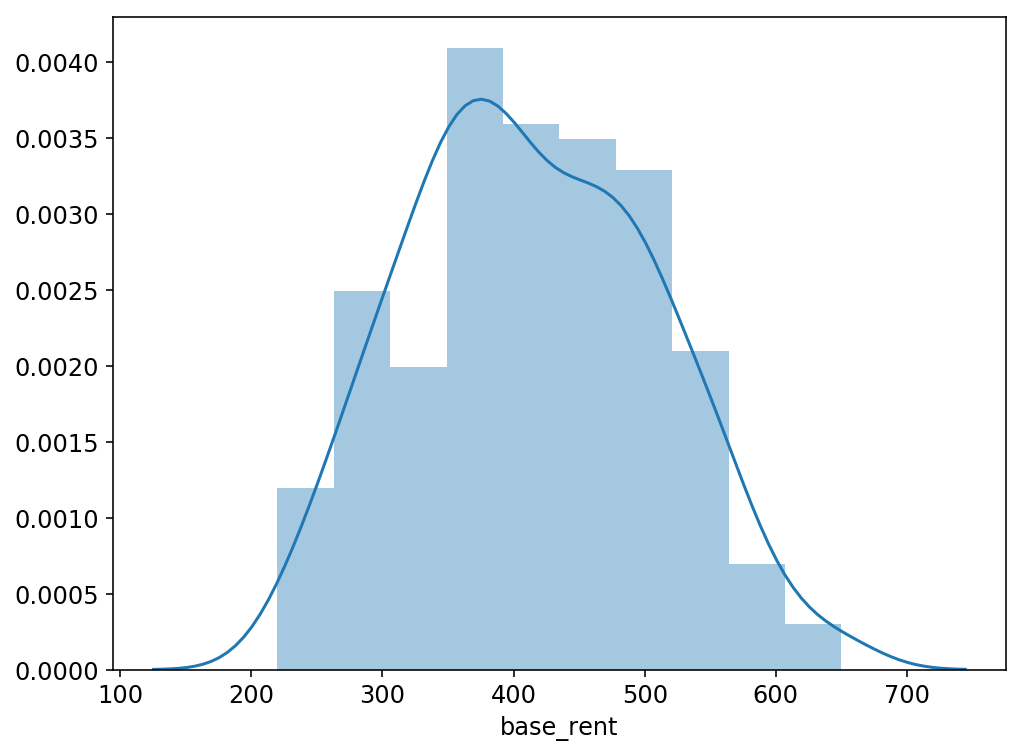

In [134]:
sns.distplot(df.base_rent);

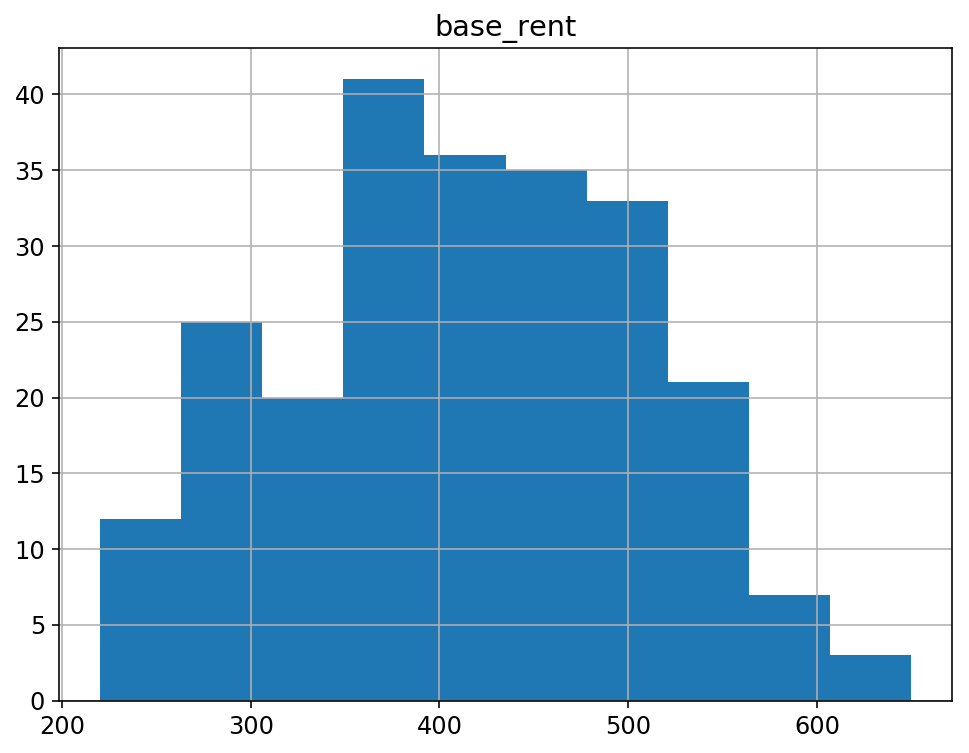

In [135]:
df.hist('base_rent');

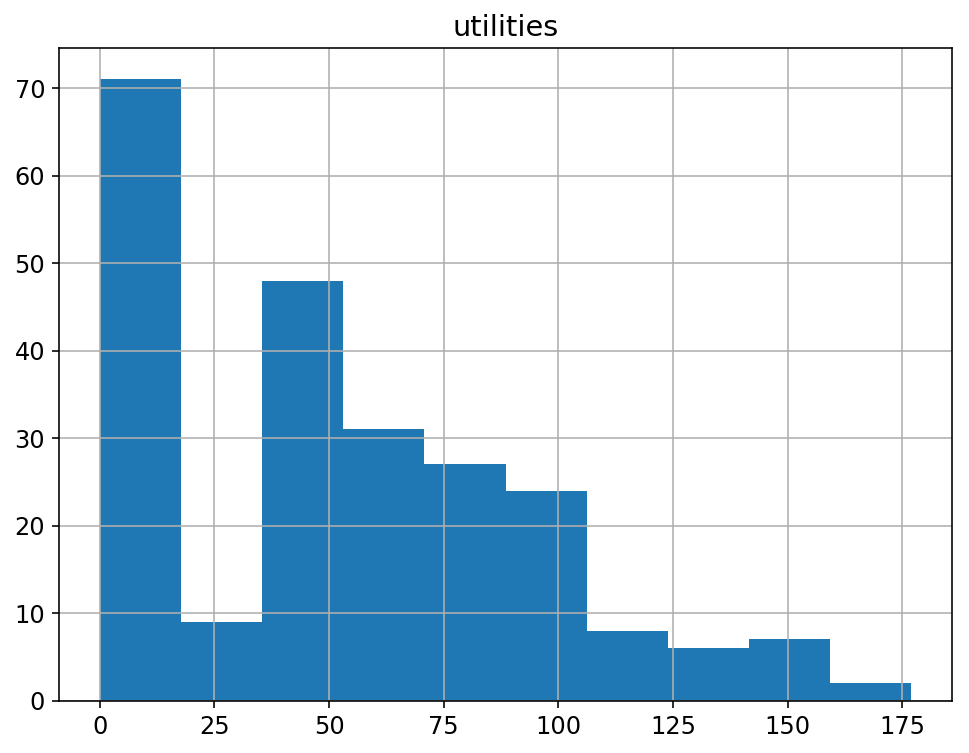

In [136]:
df.hist('utilities');

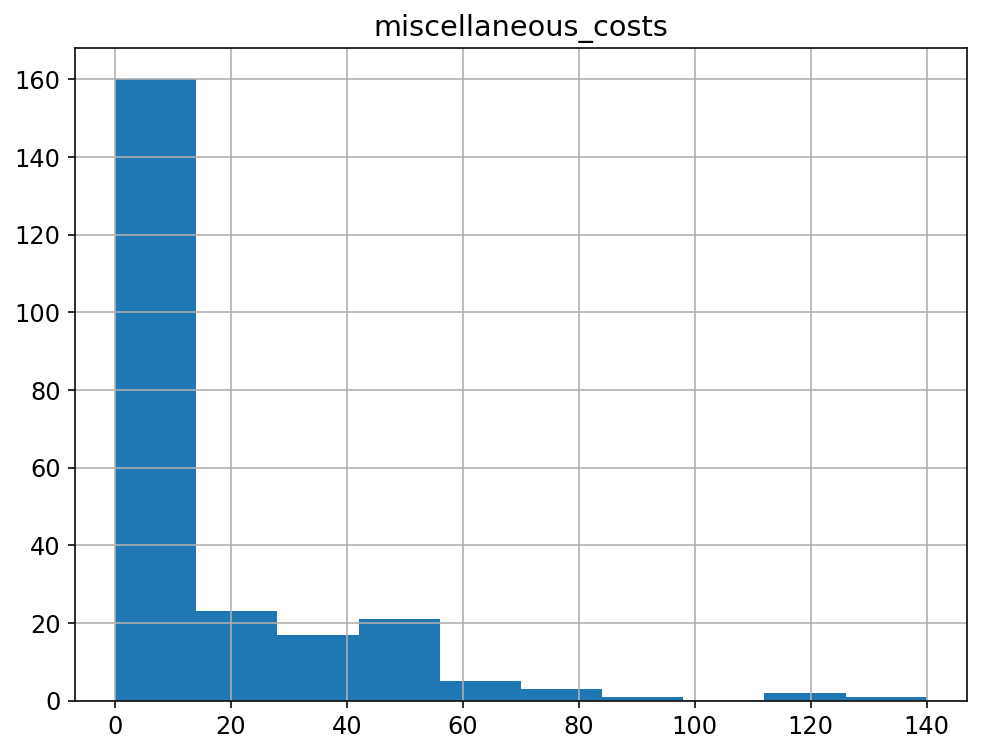

In [137]:
df.hist('miscellaneous_costs');

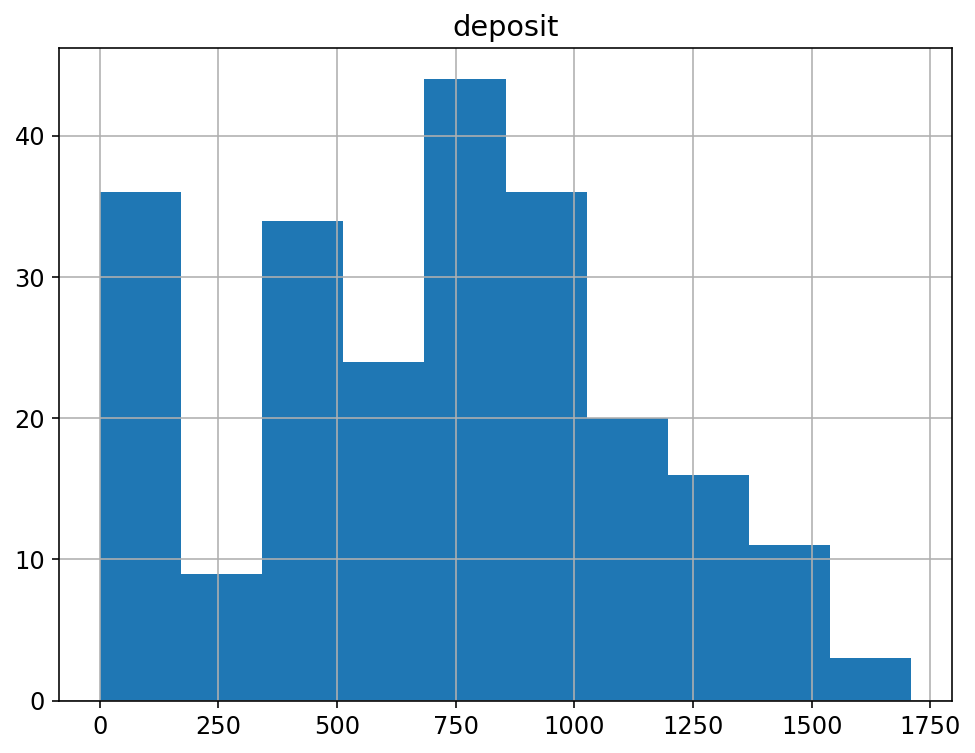

In [138]:
df.hist('deposit');

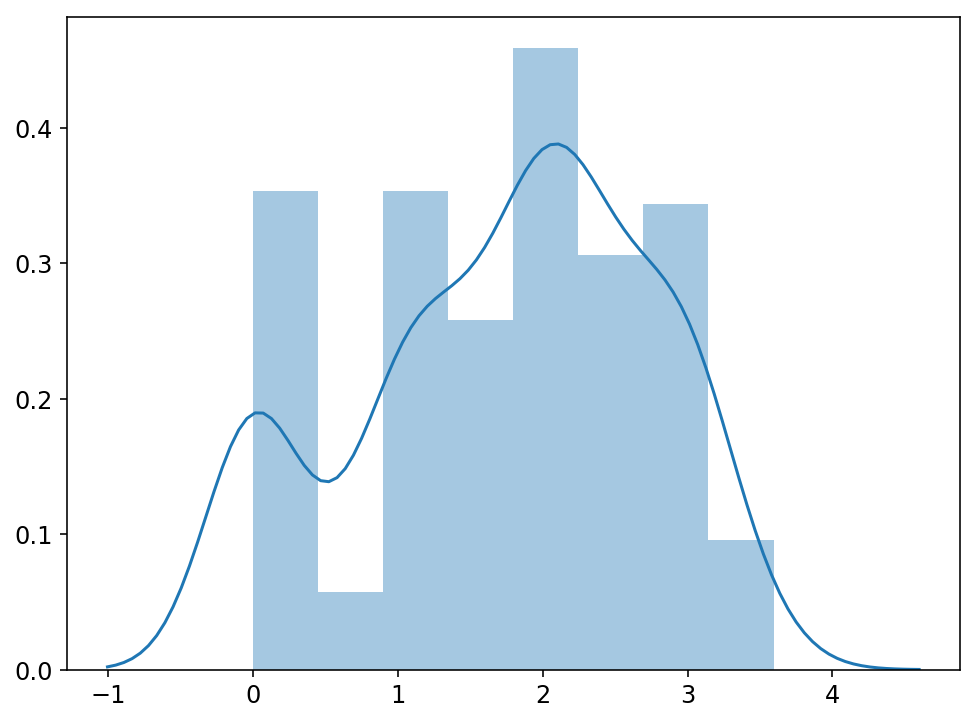

In [139]:
sns.distplot(df.deposit / df.base_rent);

In [140]:
def compare_distributions(groupby, column, **this_plot_opts):
    plot_opts = dict(histtype='stepfilled', alpha=0.2)
    plot_opts.update(this_plot_opts)
    grps = df.groupby(groupby)
    for key, grp in df.groupby(groupby):
        grp[column].plot.hist(sharex=True, sharey=True, ax=plt.gca(),
                              label=str(key), 
                              title="%s grouped by %s" % (column, groupby), 
                              **plot_opts)
    plt.legend();
    plt.minorticks_on()

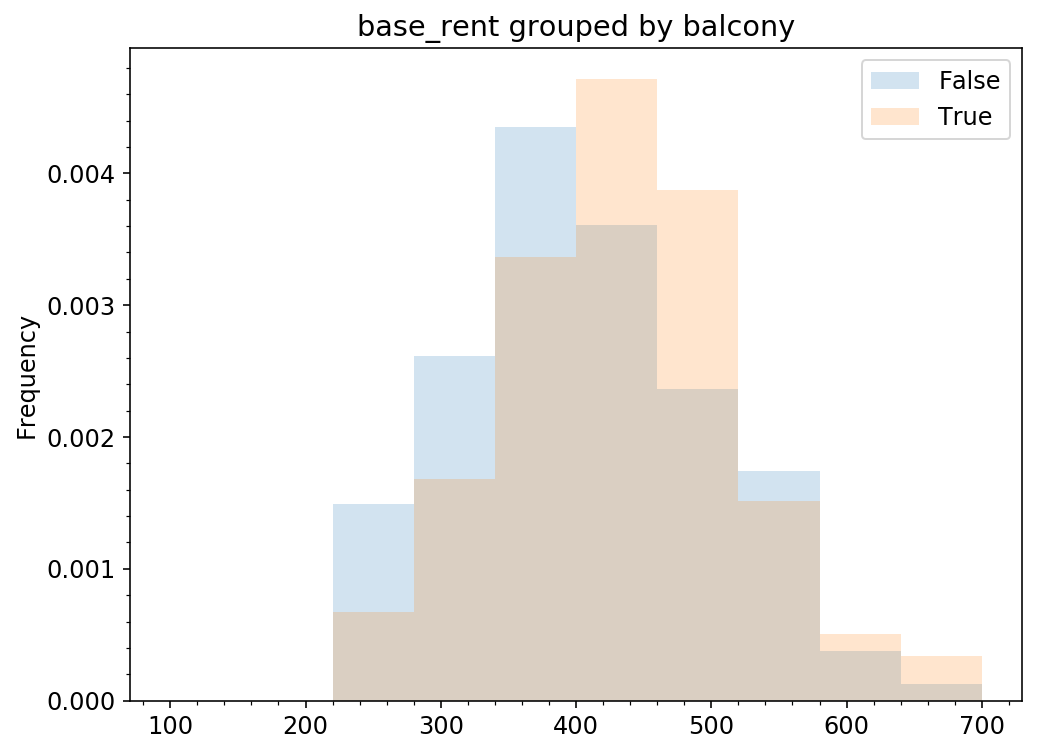

In [141]:
compare_distributions('balcony', 'base_rent', 
                      bins=10, range=[100, 700], alpha=0.2, normed=True)

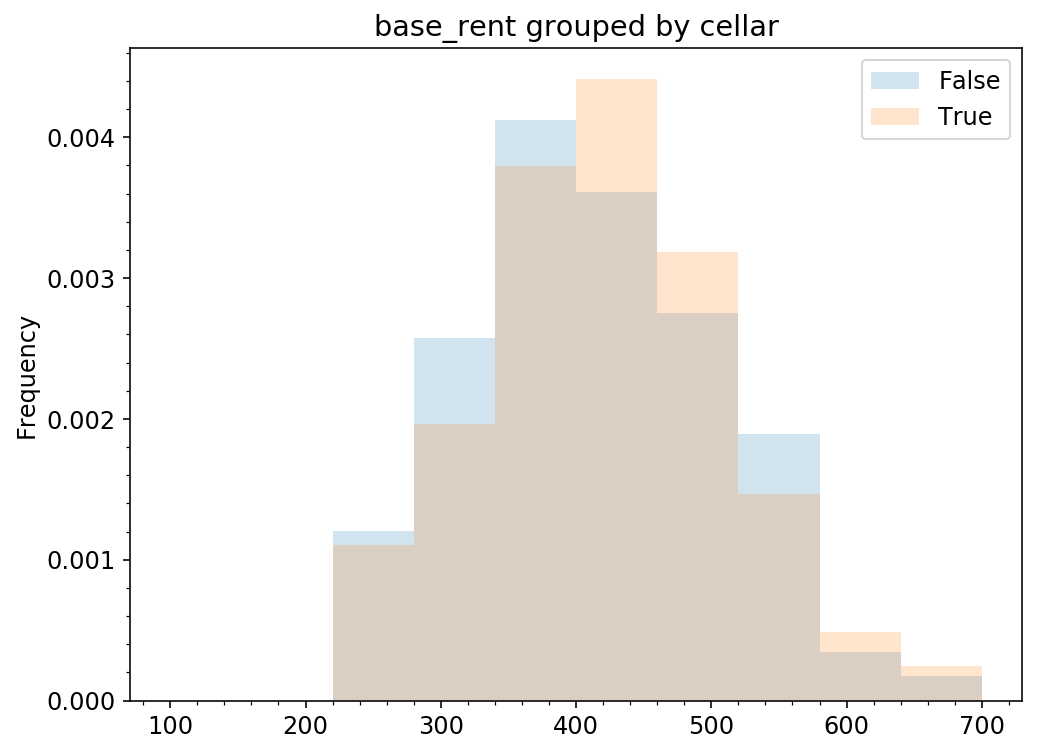

In [142]:
compare_distributions('cellar', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

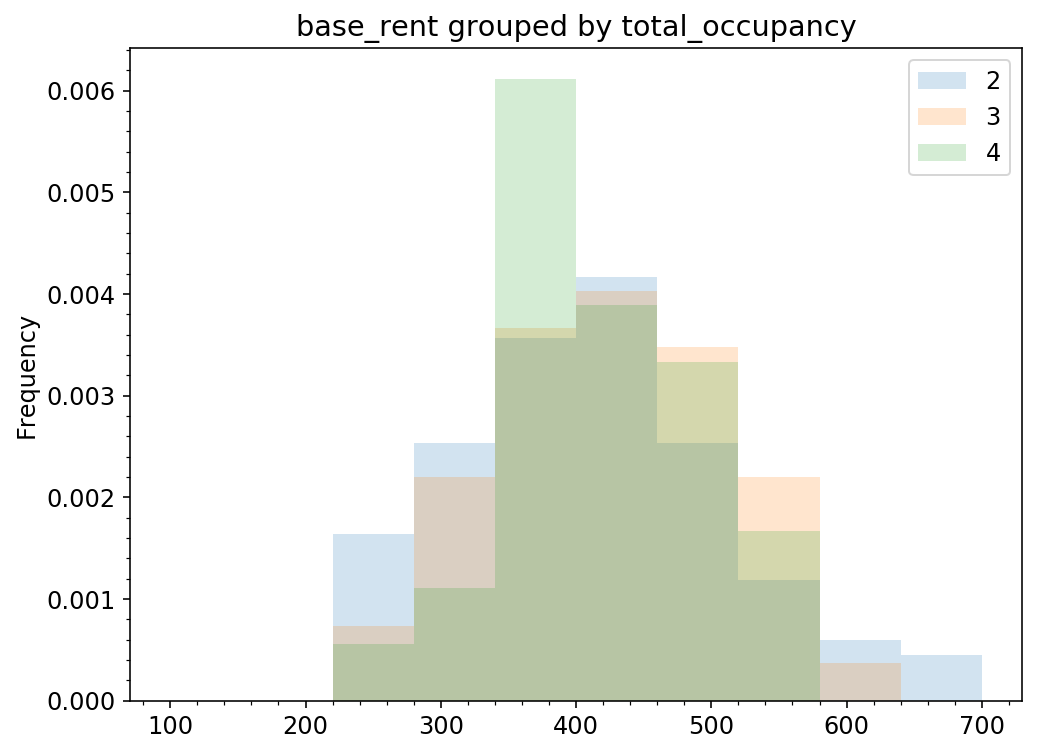

In [143]:
compare_distributions('total_occupancy', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

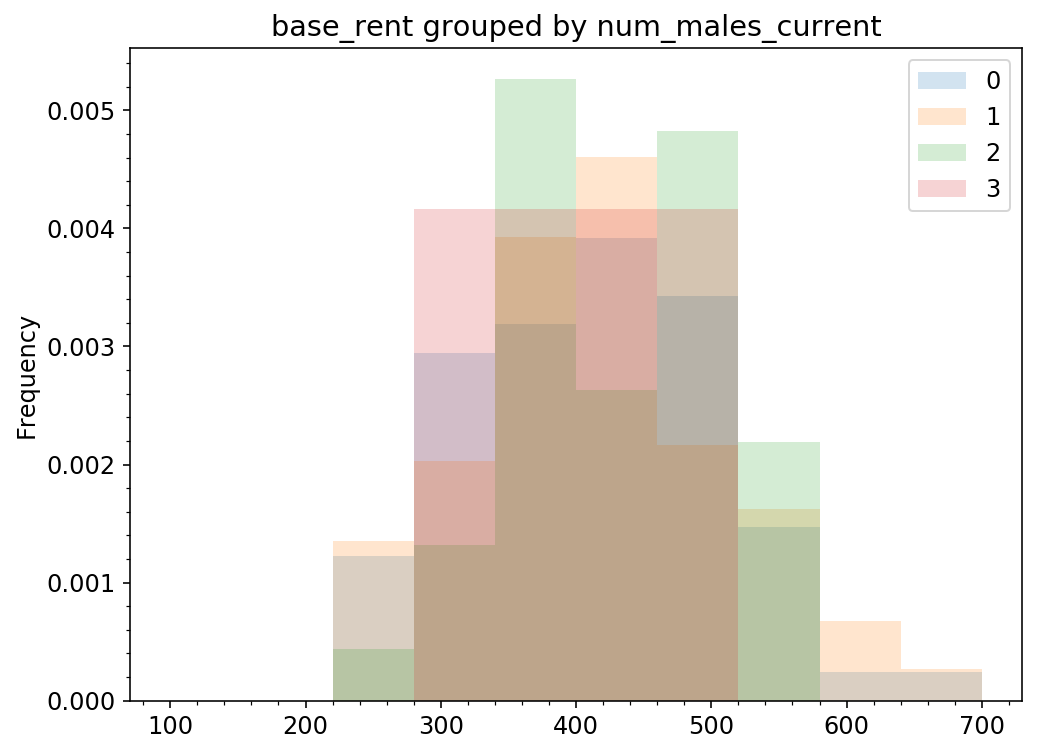

In [144]:
compare_distributions('num_males_current', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

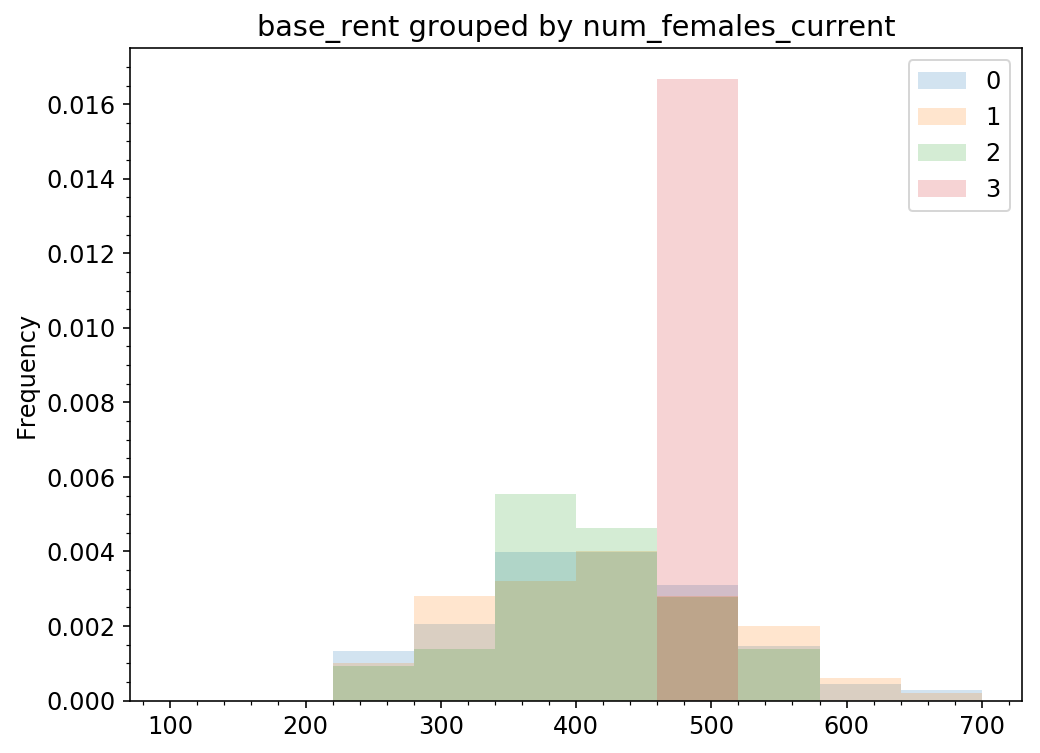

In [145]:
compare_distributions('num_females_current', 'base_rent', 
                      bins=10, range=[100, 700], histtype='stepfilled', alpha=0.2, normed=True)

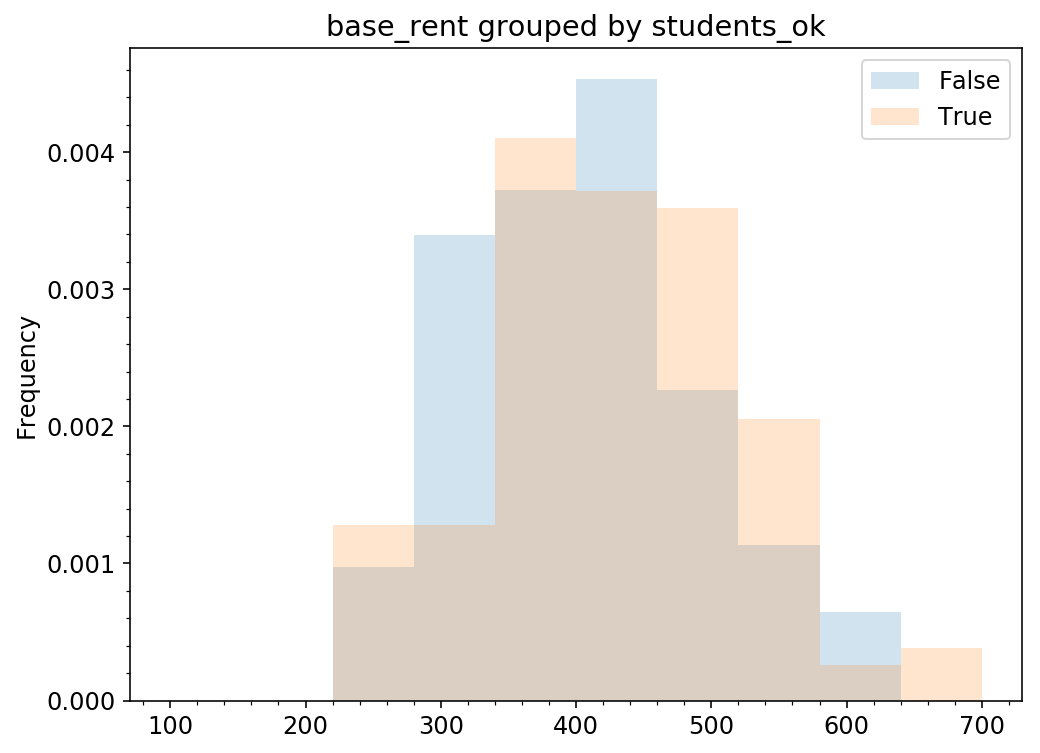

In [146]:
compare_distributions('students_ok', 'base_rent', bins=10, range=[100, 700], normed=True)

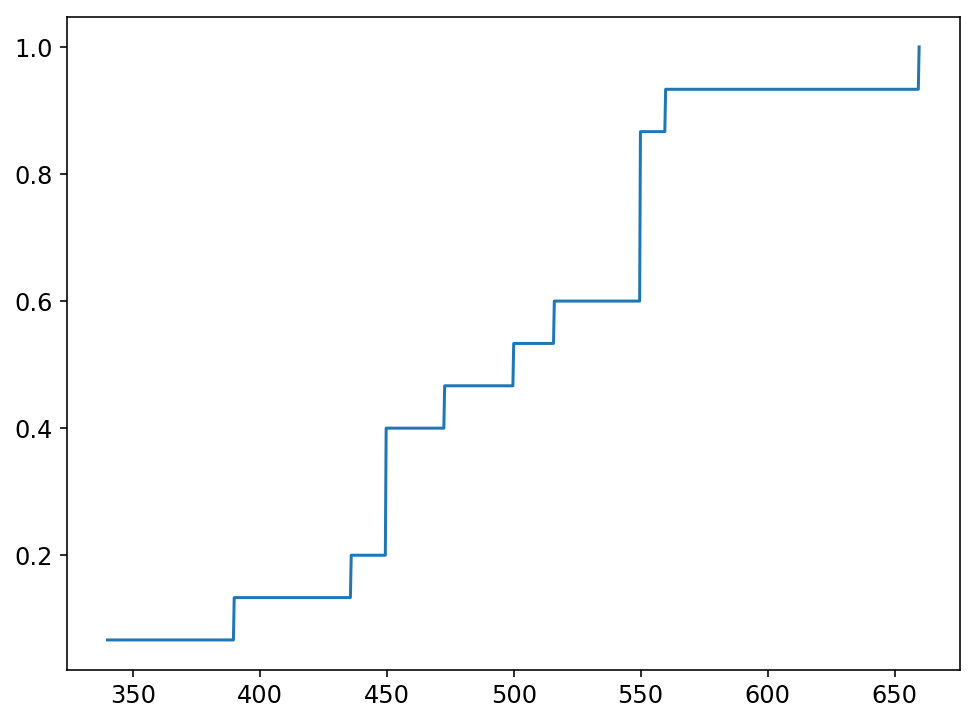

In [147]:
values, bins = np.histogram(df.query('room_area == 20').total_rent.values, bins=1000)
cumul = np.cumsum(values)
plt.plot(bins[:-1], cumul / cumul.max())

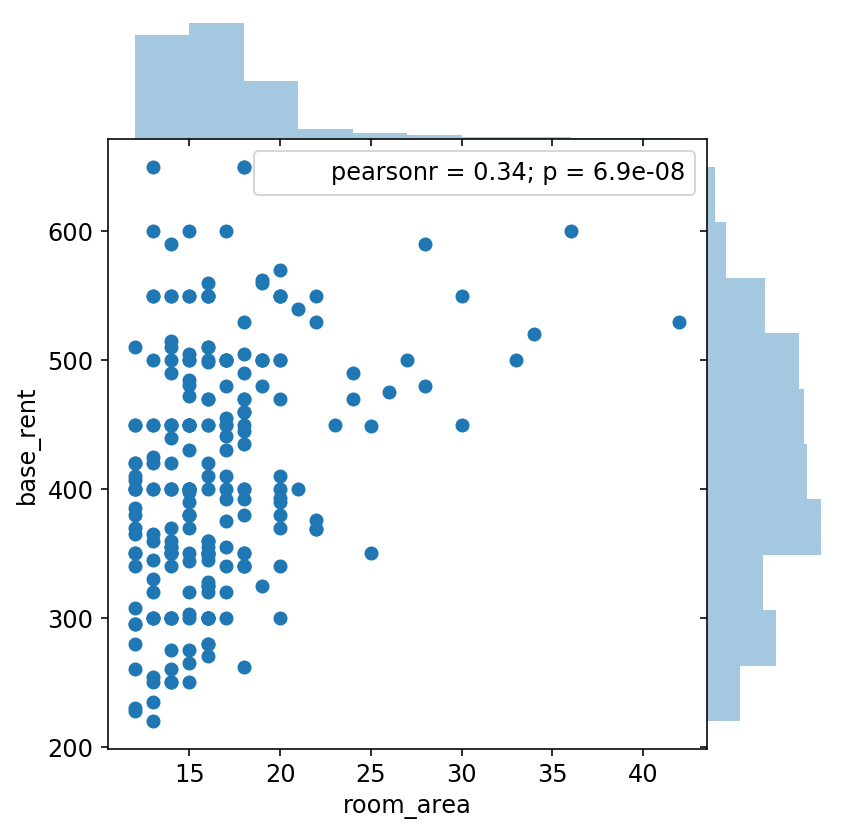

In [148]:
sns.jointplot(x='room_area', y='base_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

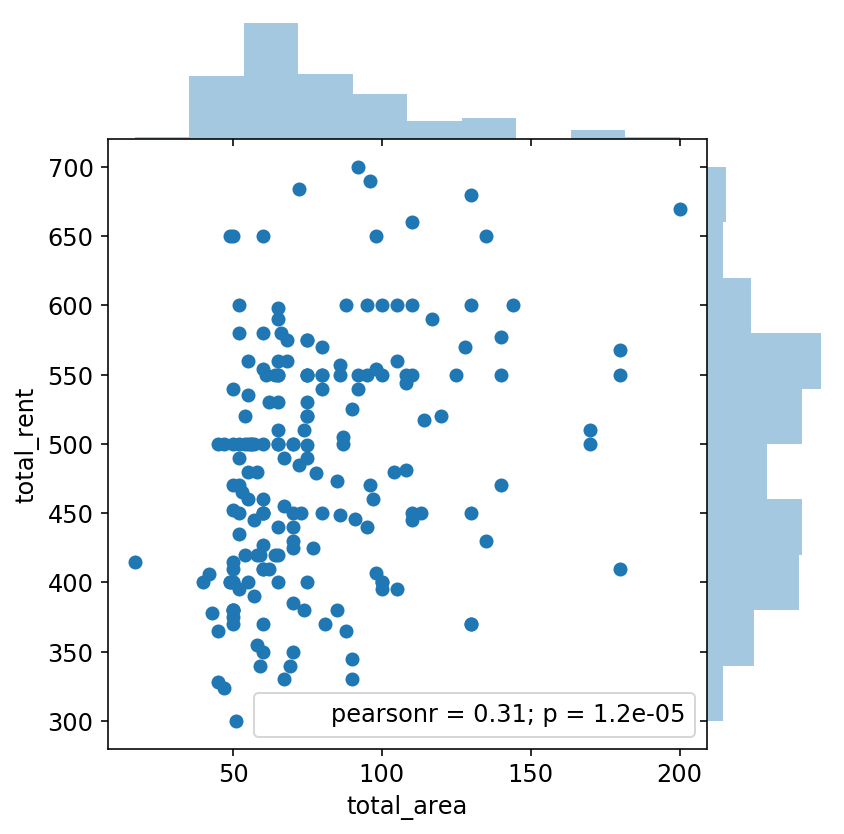

In [149]:
sns.jointplot(x='total_area', y='total_rent', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

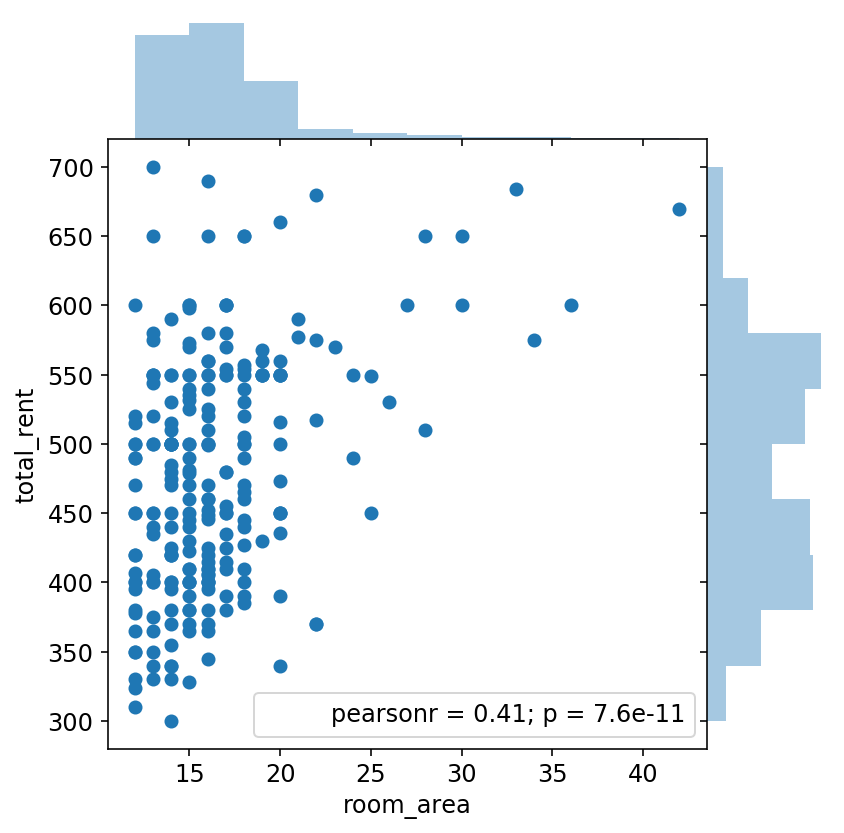

In [150]:
sns.jointplot(x='room_area', y='total_rent', 
              data=df, 
              space=0, marginal_kws={'bins': 10});

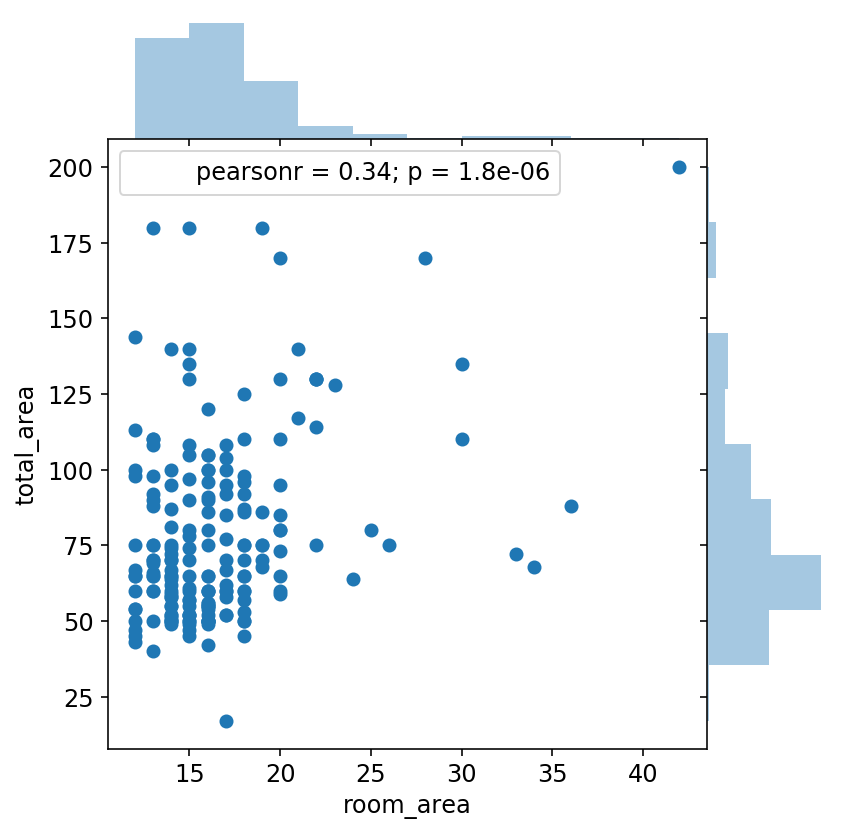

In [151]:
sns.jointplot(x='room_area', y='total_area', 
              data=df.query('total_area>0'), 
              space=0, marginal_kws={'bins': 10});

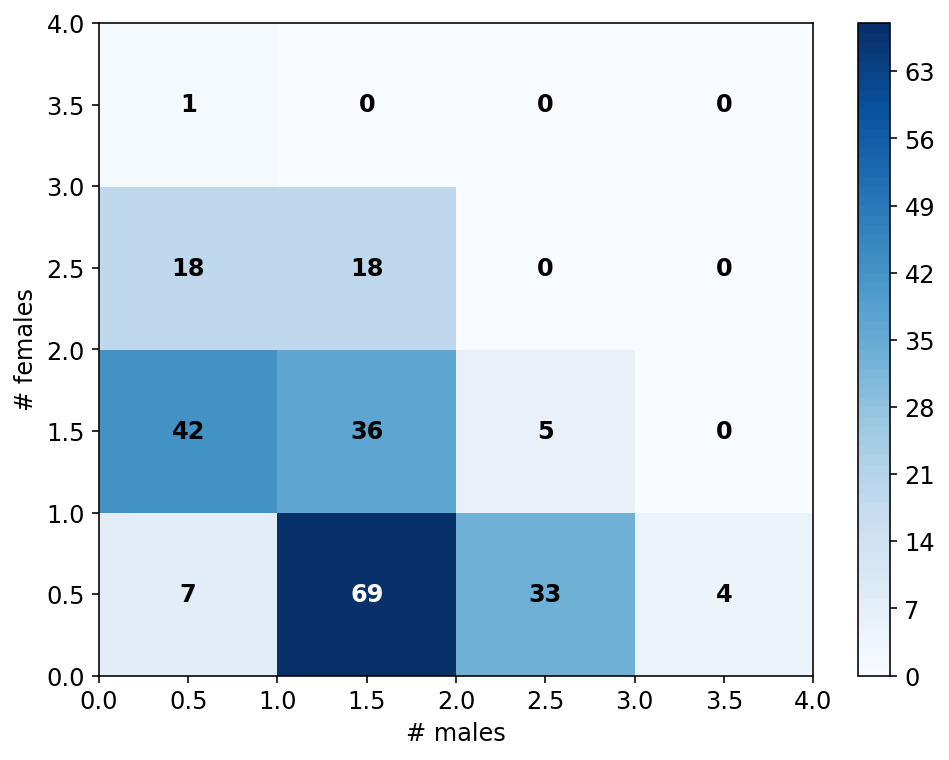

In [152]:
n_person = 5
vals, xbins, ybins = np.histogram2d(df.num_males_current, df.num_females_current,
                                    bins=[range(n_person), range(n_person)])
maxz = int(vals.max())
hist, xbins, ybins, im = plt.hist2d(df.num_males_current, df.num_females_current,
                                    bins=[range(n_person), range(n_person)],
                                    norm=colors.BoundaryNorm(boundaries=range(maxz), ncolors=256), 
                                    cmap='Blues');
for i in range(len(ybins)-1):
    for j in range(len(xbins)-1):
        hist[i,j] = int(hist[i,j])
        plt.text(xbins[j]+0.5,ybins[i]+0.5, "%d" % hist[j,i], 
                 color="w" if hist[j,i] > maxz*(5./8) else 'k', 
                 ha="center", va="center", fontweight="bold")

plt.xlabel('# males')
plt.ylabel('# females')
plt.colorbar();

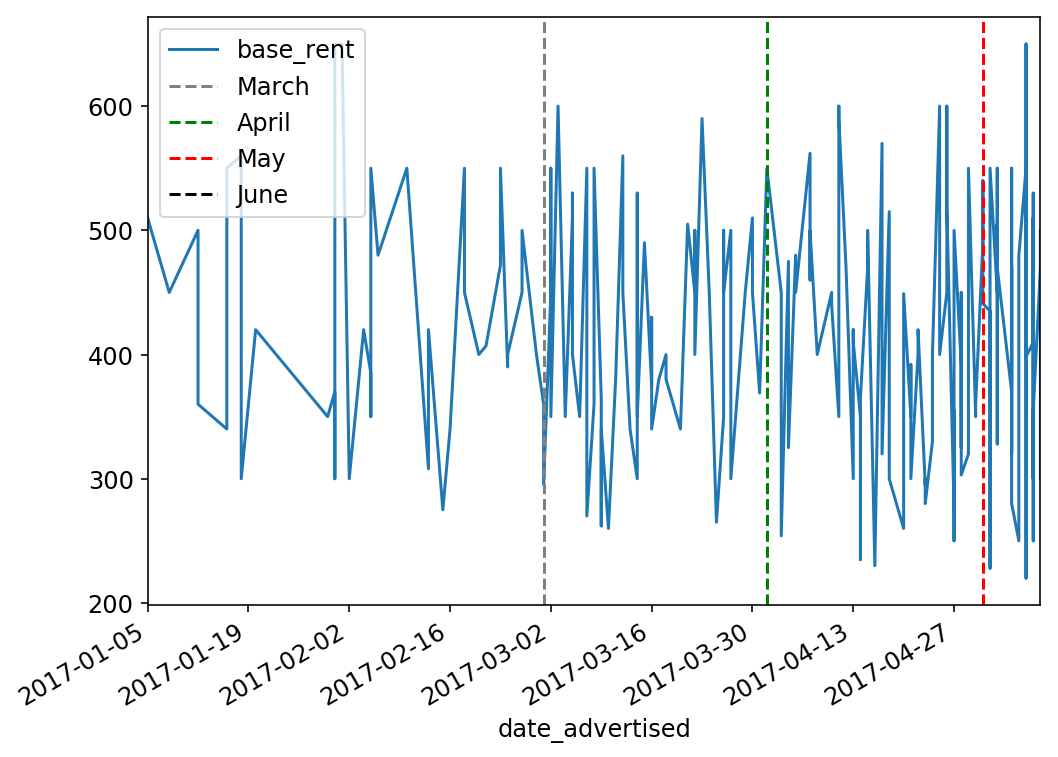

In [153]:
df.plot(x='date_advertised', y='base_rent');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.legend();

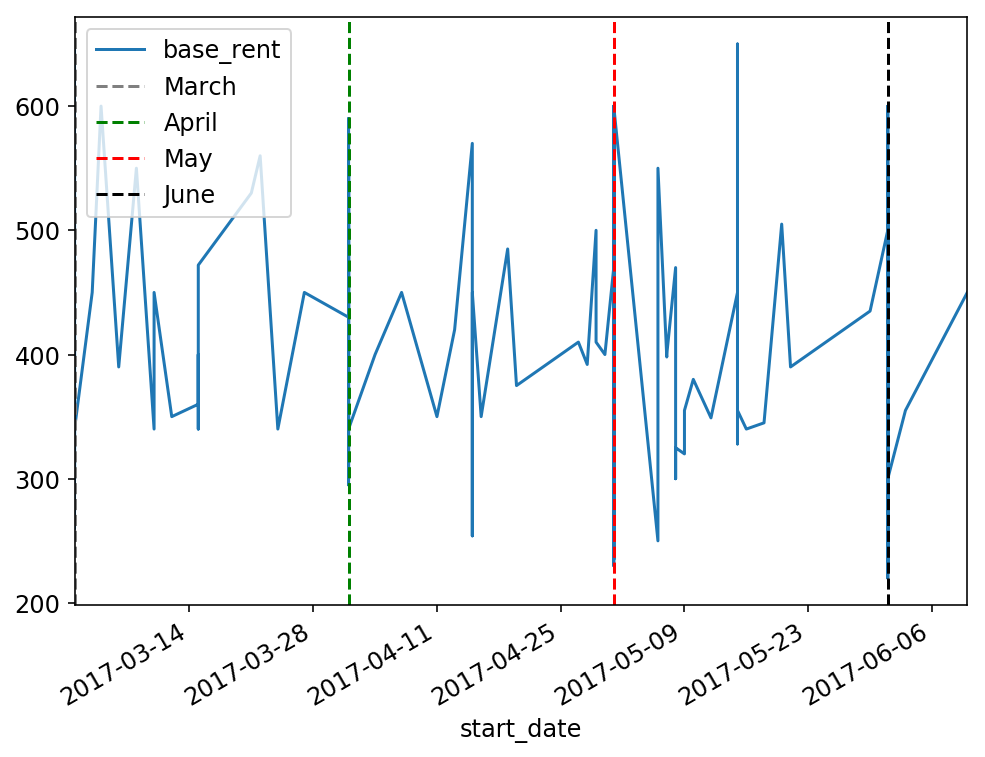

In [154]:
df.plot(x='start_date', y='base_rent');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.legend();

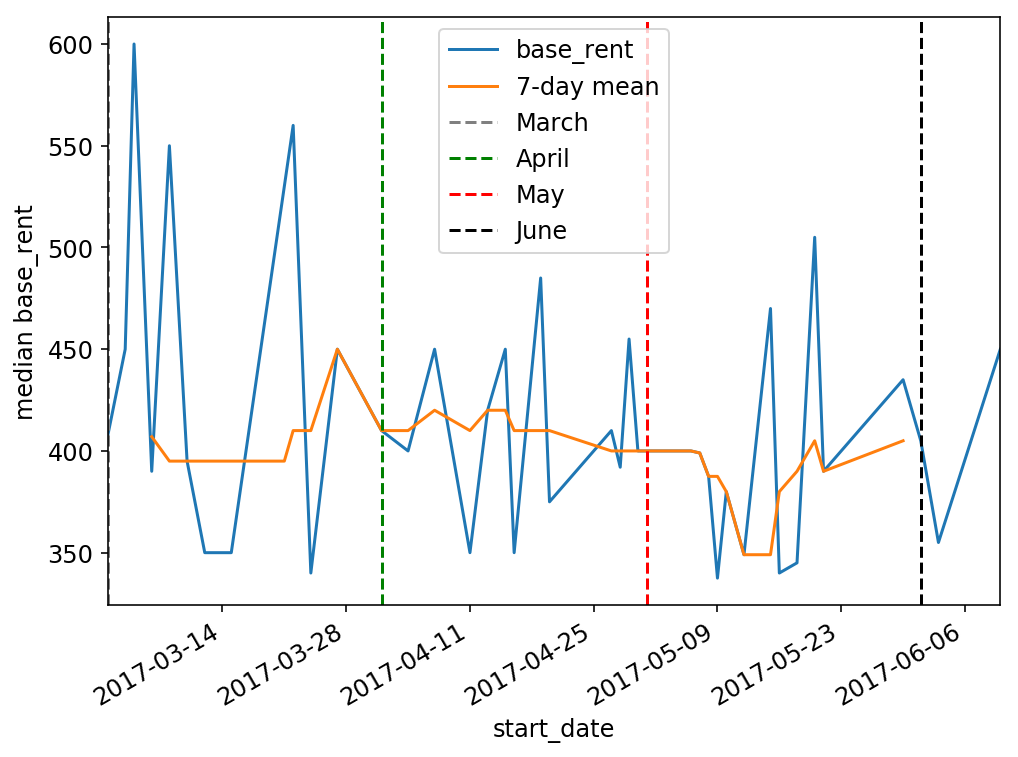

In [155]:
day_ave = df.groupby('start_date').base_rent.median()
ax = day_ave.plot()
window = 7
rolling = day_ave.rolling(window, center=True).median()
rolling.index = day_ave.index
rolling.plot(ax=ax, label="%d-day mean" % window)
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.ylabel('median base_rent');
plt.legend();

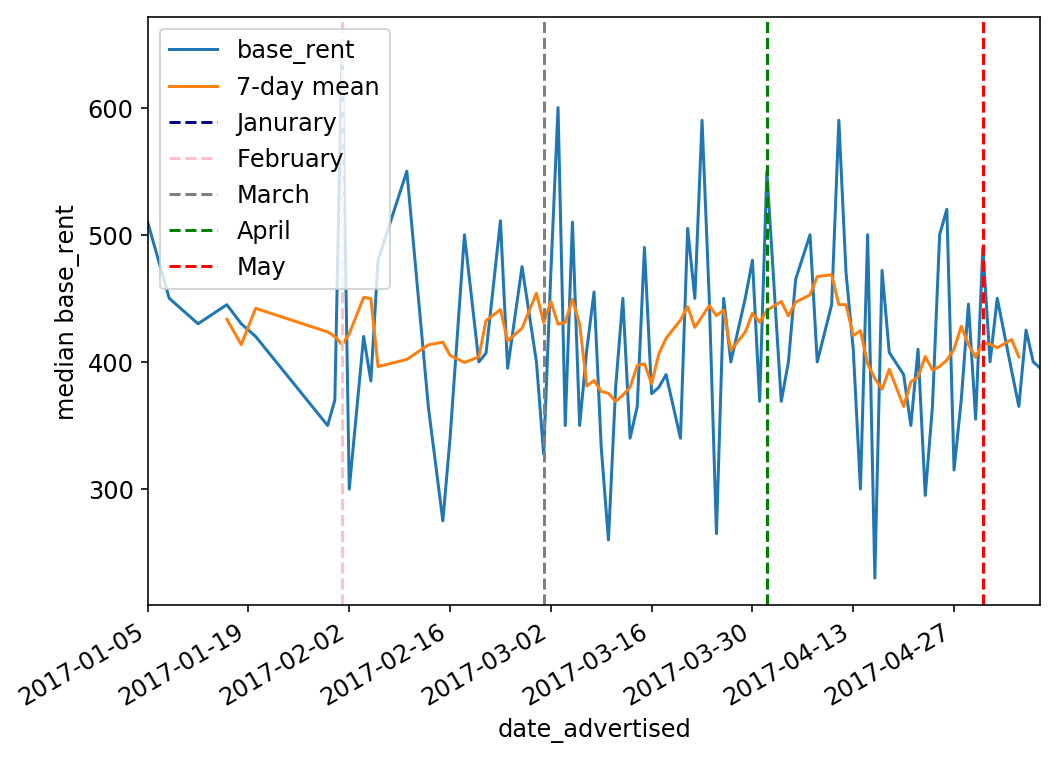

In [196]:
day_ave = df.groupby('date_advertised').base_rent.median()
ax = day_ave.plot()
window = 7
rolling = day_ave.rolling(window, center=True).mean()
rolling.index = day_ave.index
rolling.plot(ax=ax, label="%d-day mean" % window)
plt.axvline('2017-01-01', c='darkblue', linestyle='dashed', label='Janurary');
plt.axvline('2017-02-01', c='pink', linestyle='dashed', label='February');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
# plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.ylabel('median base_rent');
plt.legend();

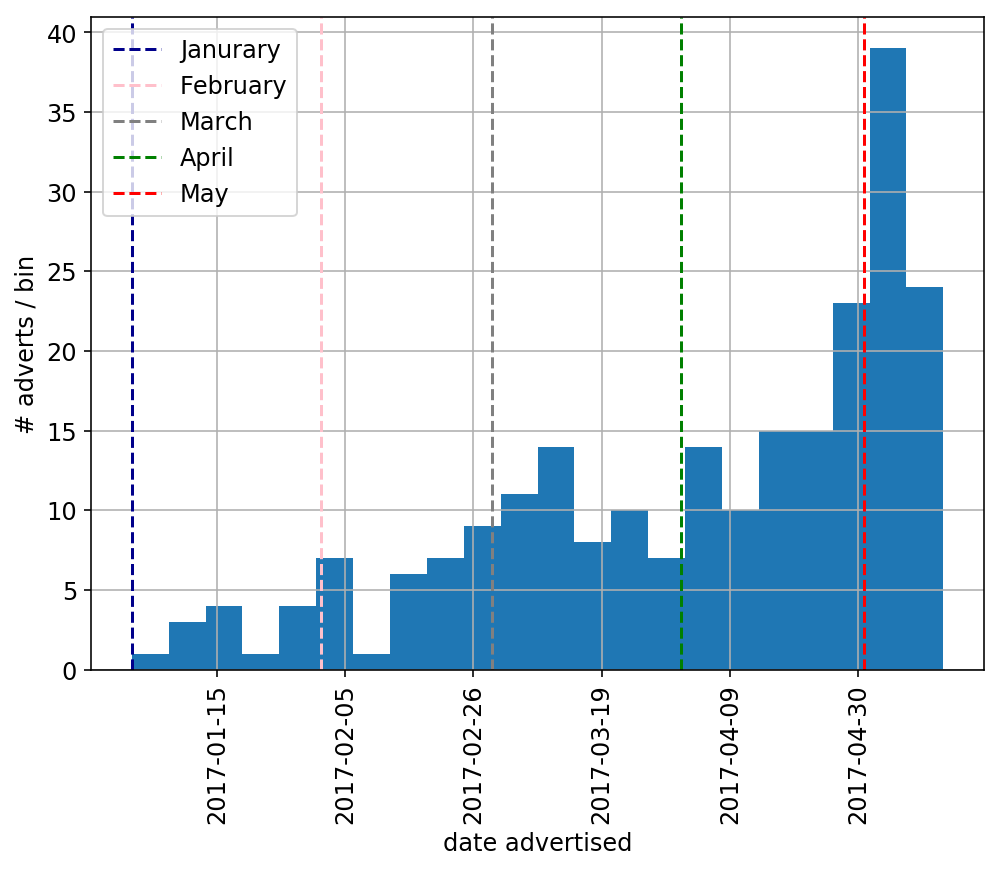

In [195]:
df.date_advertised.hist(bins=22, xrot=90, range=['2017-01-01', '2017-05-14']);
plt.ylabel('# adverts / bin')
plt.axvline('2017-01-01', c='darkblue', linestyle='dashed', label='Janurary');
plt.axvline('2017-02-01', c='pink', linestyle='dashed', label='February');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
# plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.xlabel("date advertised")
plt.legend();

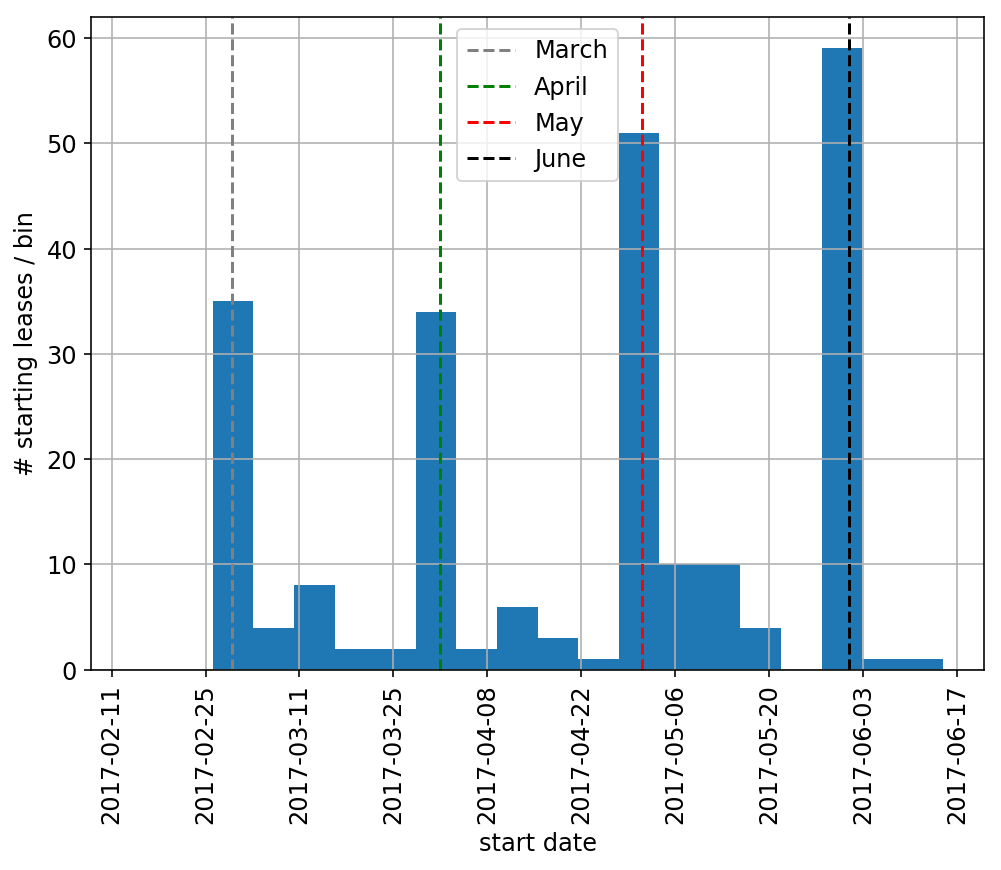

In [158]:
df.start_date.hist(bins=20, xrot=90, range=['2017-02-14', '2017-06-15']);
plt.ylabel('# starting leases / bin')
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.xlabel("start date");
plt.legend();

In [159]:
df.start_date.value_counts().head()

2017-06-01    58
2017-05-01    47
2017-04-01    34
2017-03-01    33
2017-05-15     8
Name: start_date, dtype: int64

In [160]:
lag = df.start_date - df.date_advertised

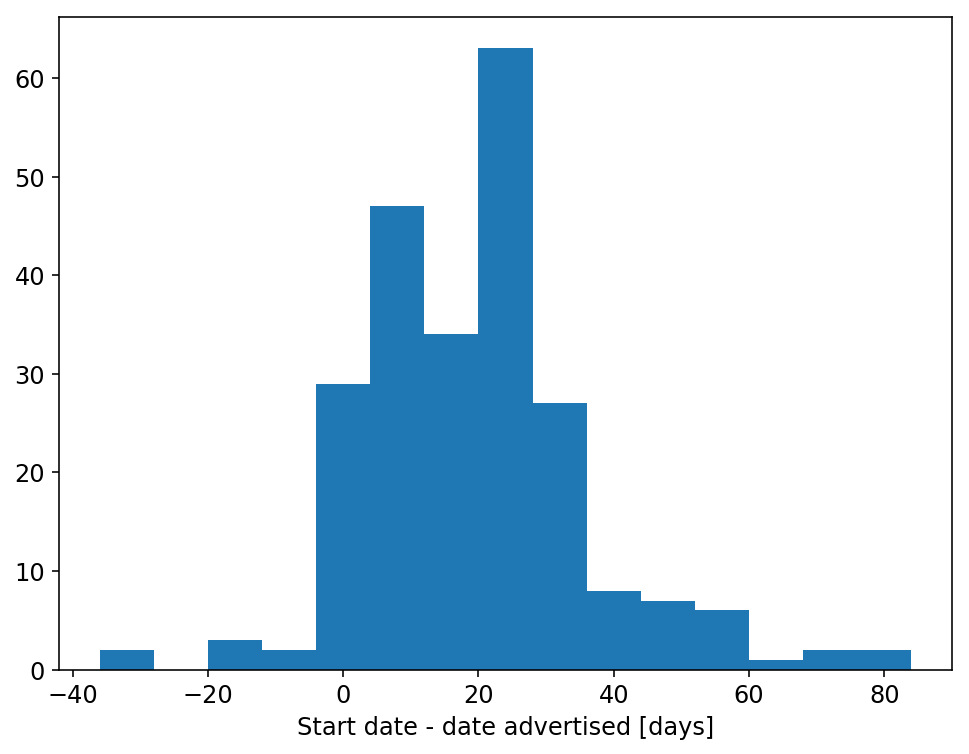

In [161]:
plt.hist(lag / pd.Timedelta(days=1), bins=15);
plt.xlabel("Start date - date advertised [days]");

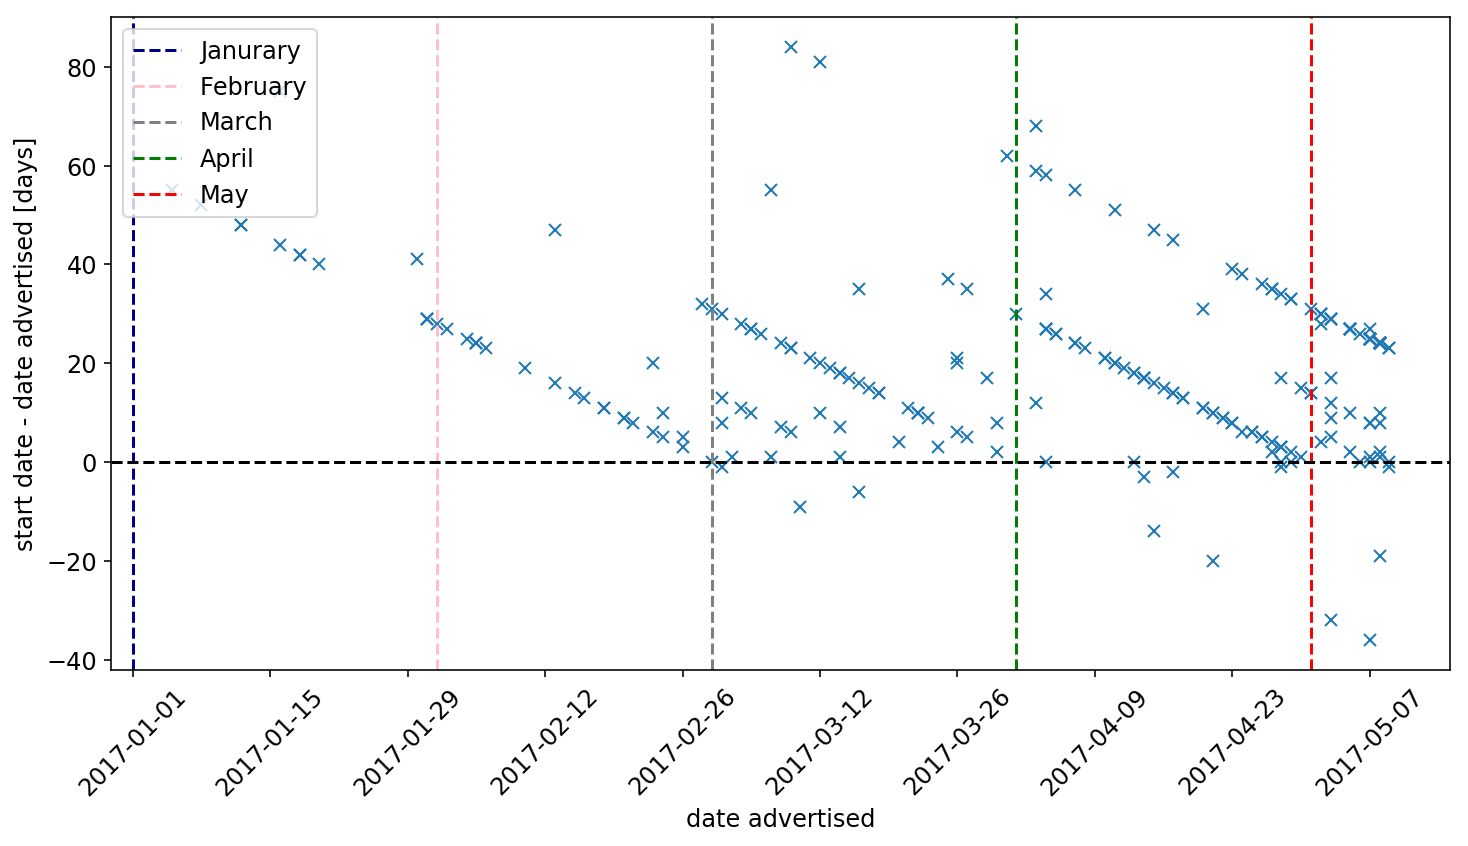

In [191]:
plt.plot(df.date_advertised, lag / pd.Timedelta(days=1), 'x')
plt.xlabel('date advertised');
plt.ylabel('start date - date advertised [days]');
plt.gcf().set_size_inches(12, 6);
plt.axvline('2017-01-01', c='darkblue', linestyle='dashed', label='Janurary');
plt.axvline('2017-02-01', c='pink', linestyle='dashed', label='February');
plt.axvline('2017-03-01', c='grey', linestyle='dashed', label='March');
plt.axvline('2017-04-01', c='green', linestyle='dashed', label='April');
plt.axvline('2017-05-01', c='red', linestyle='dashed', label='May');
# plt.axvline('2017-06-01', c='black', linestyle='dashed', label='June');
plt.legend(loc=2);
plt.axhline(0, c='black', linestyle='dashed');
plt.xticks(rotation=45);

In [163]:
df.groupby('total_occupancy').base_rent.describe()

,count,mean,std,min,25%,50%,75%,max
total_occupancy,,,,,,,,
2,112.0,407.616071,100.082601,228.0,337.00,400.0,470.0,650.0
3,91.0,421.032967,91.491888,220.0,350.00,420.0,500.0,600.0
4,30.0,413.966667,75.732963,275.0,351.25,400.0,477.5,562.0


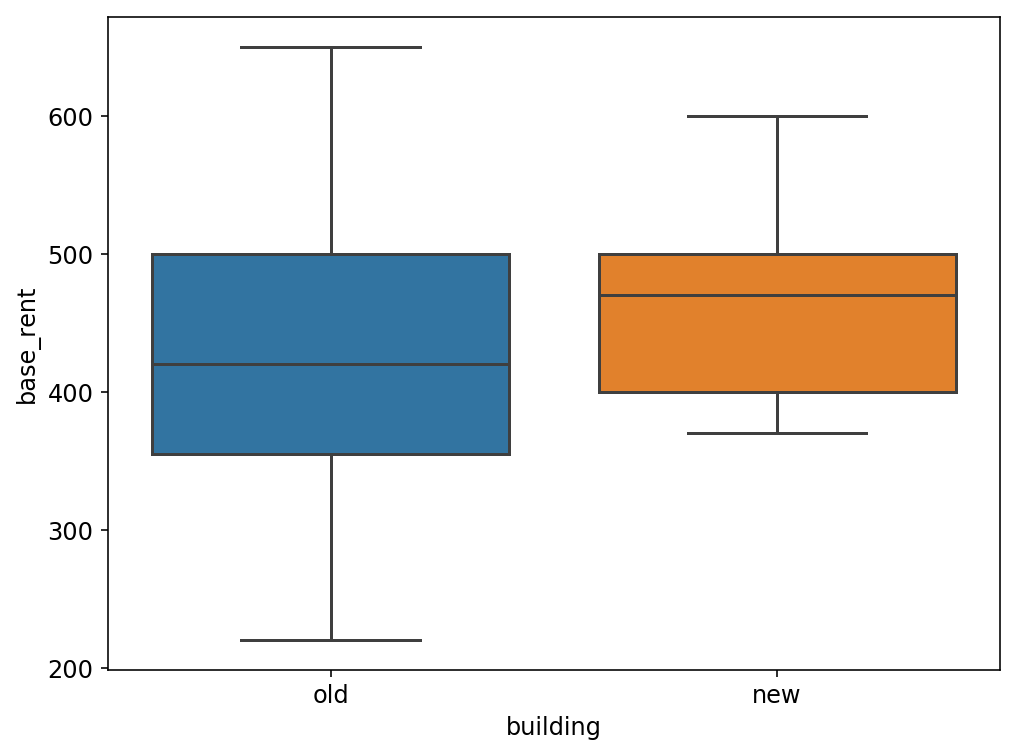

In [164]:
sns.boxplot(y='base_rent', x='building', data=df);

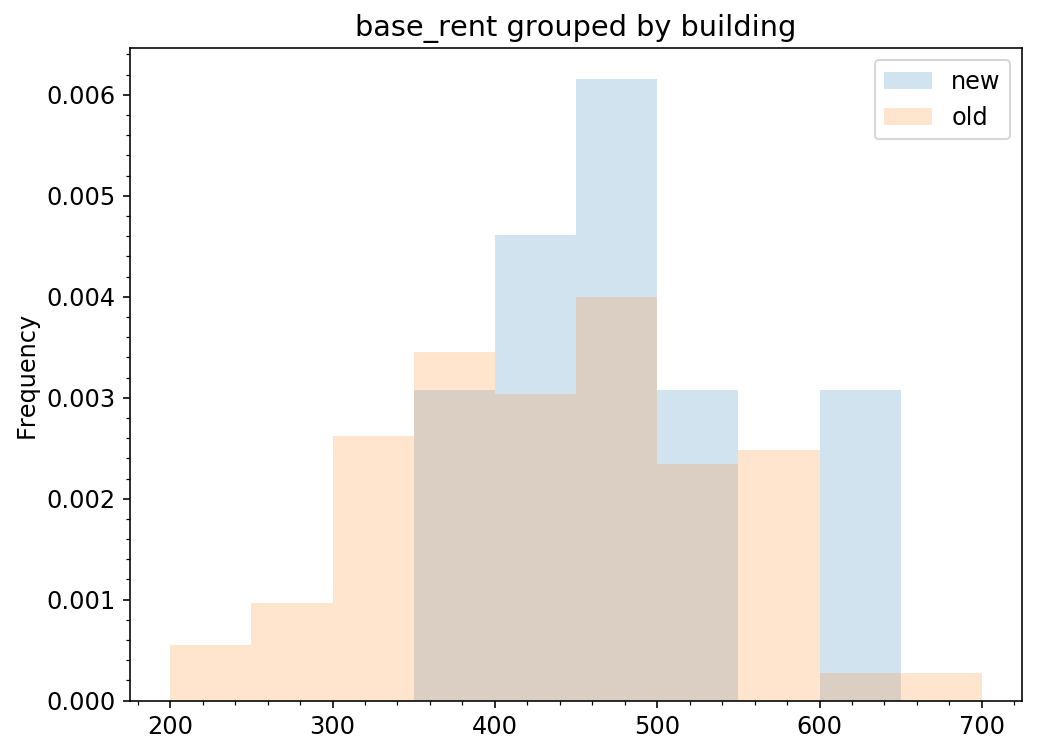

In [165]:
compare_distributions('building', 'base_rent', bins=10, range=[200, 700], normed=True)

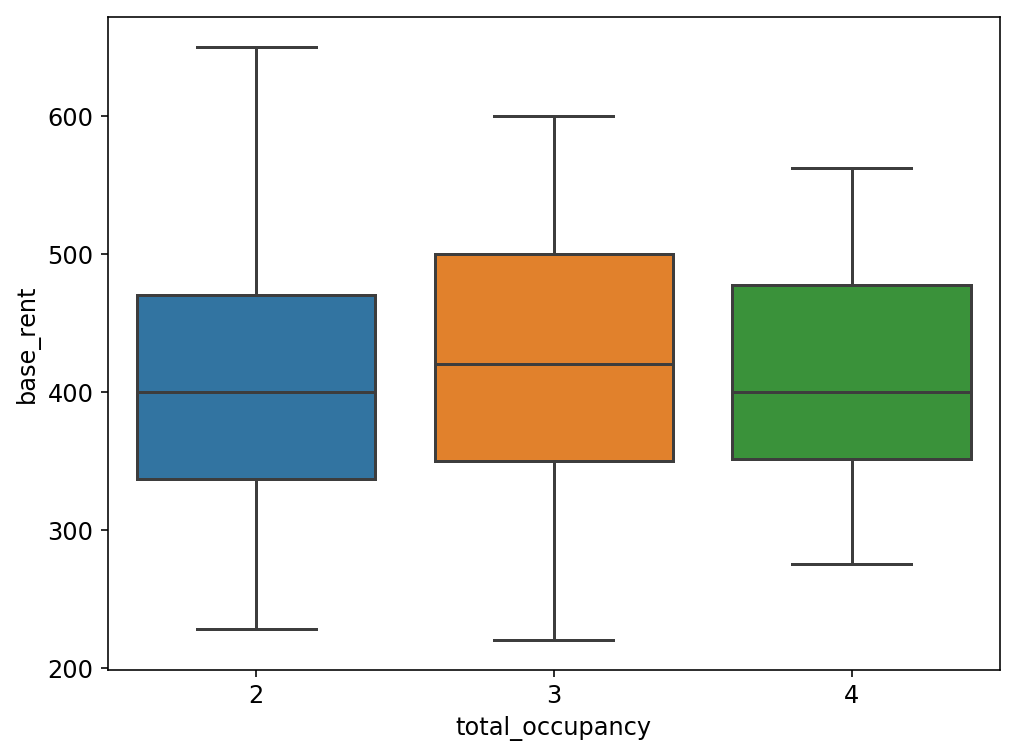

In [166]:
sns.boxplot(y='base_rent', x='total_occupancy', data=df);

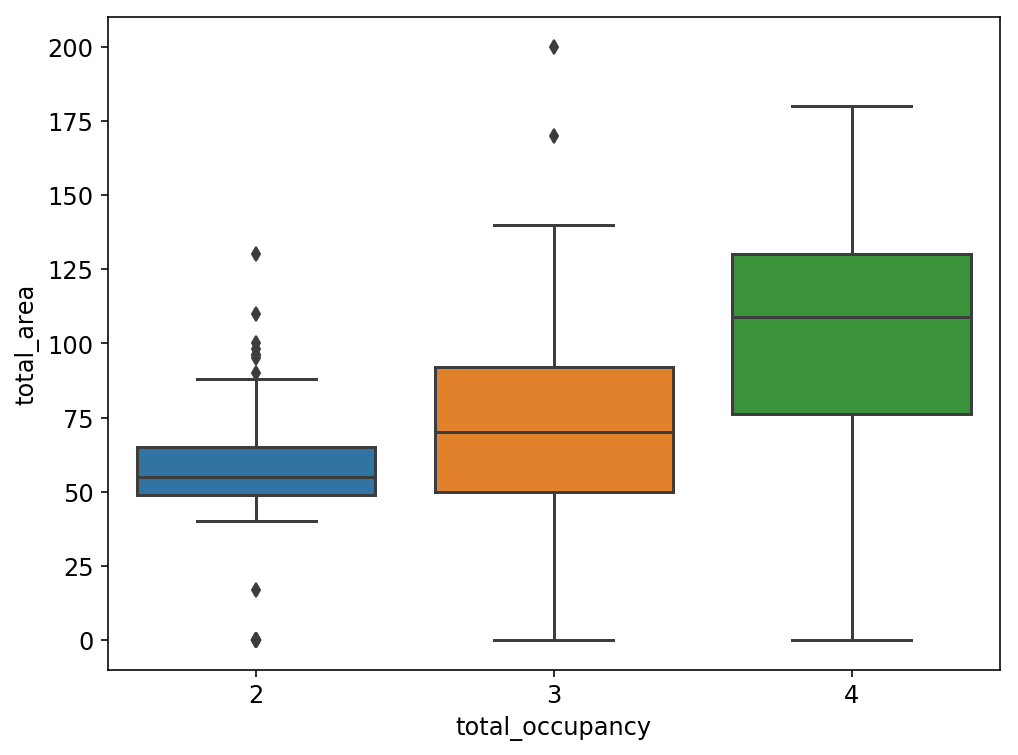

In [167]:
sns.boxplot(y='total_area', x='total_occupancy', data=df);

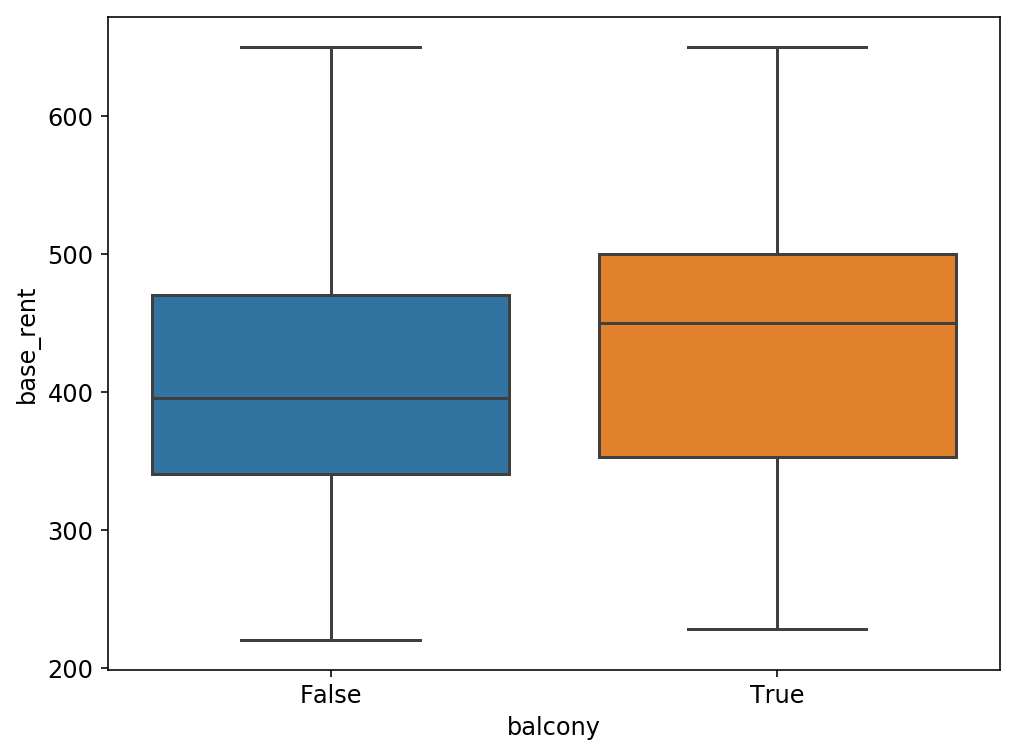

In [168]:
sns.boxplot(y='base_rent', x='balcony', data=df);

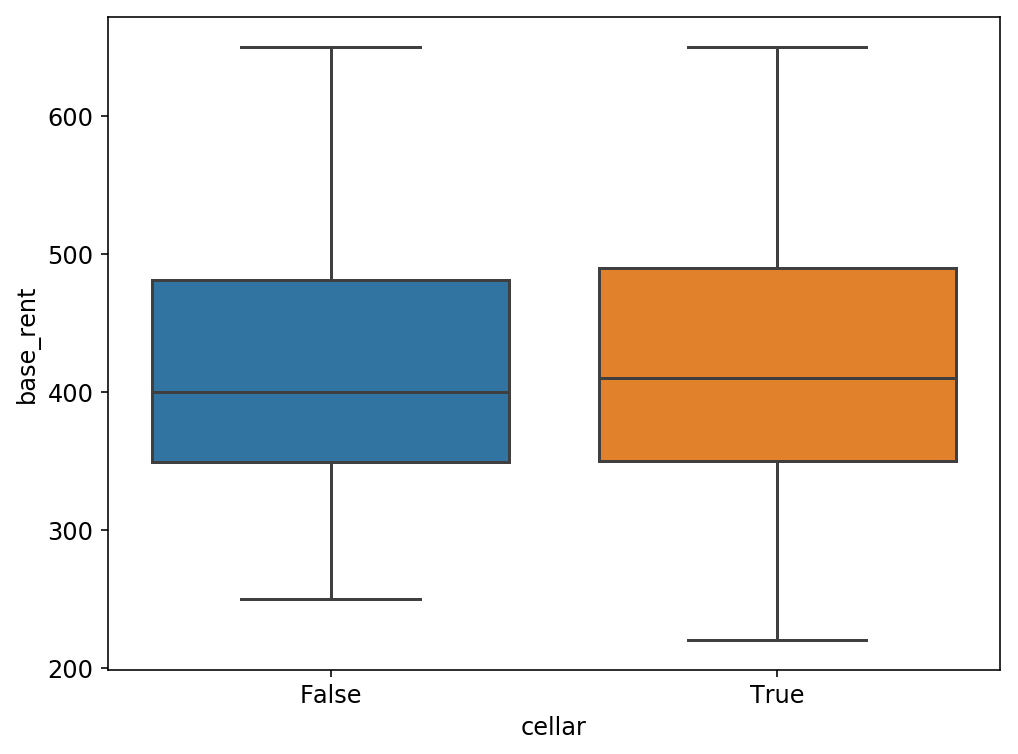

In [169]:
sns.boxplot(y='base_rent', x='cellar', data=df);

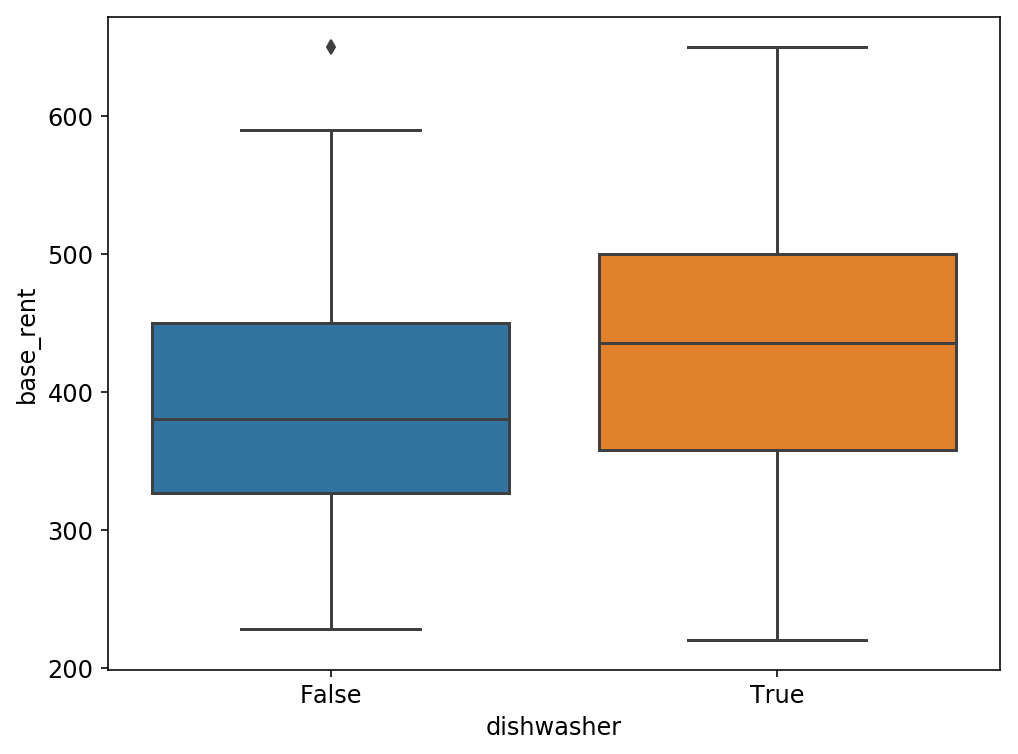

In [170]:
sns.boxplot(y='base_rent', x='dishwasher', data=df);

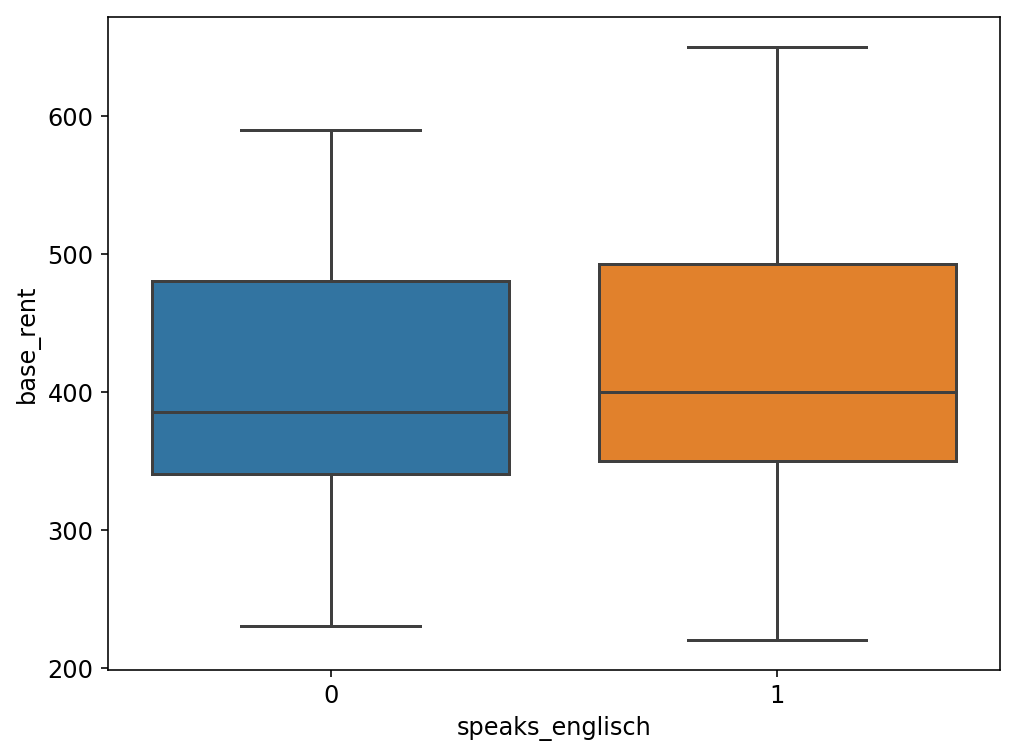

In [171]:
sns.boxplot(y='base_rent', x='speaks_englisch', data=df);

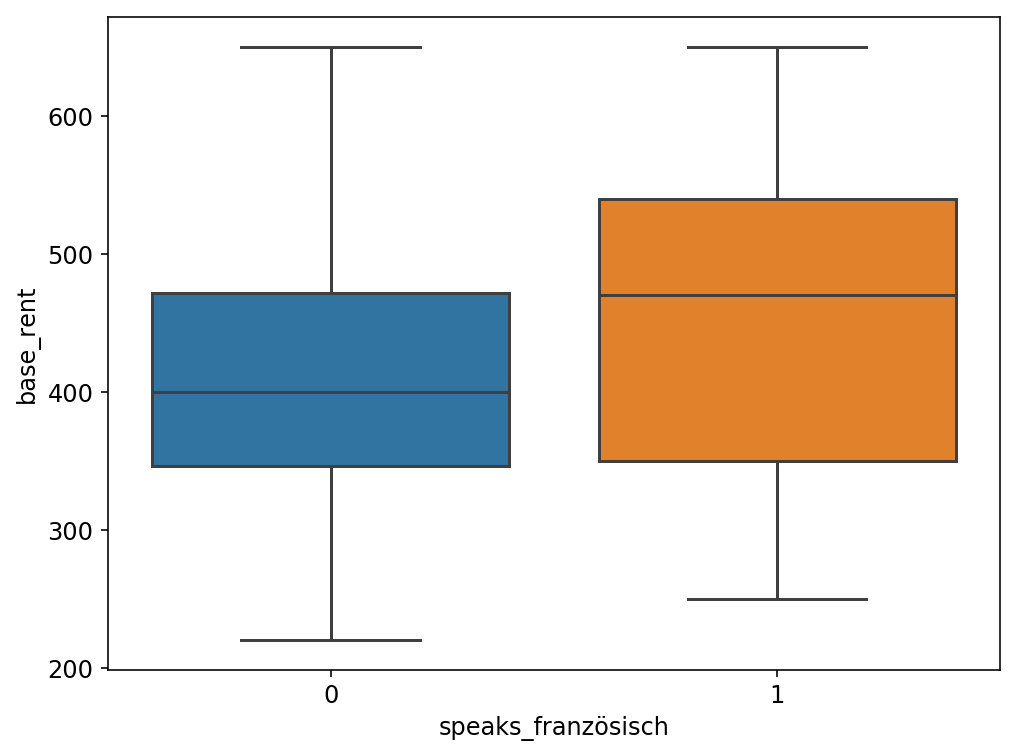

In [172]:
sns.boxplot(y='base_rent', x='speaks_französisch', data=df);

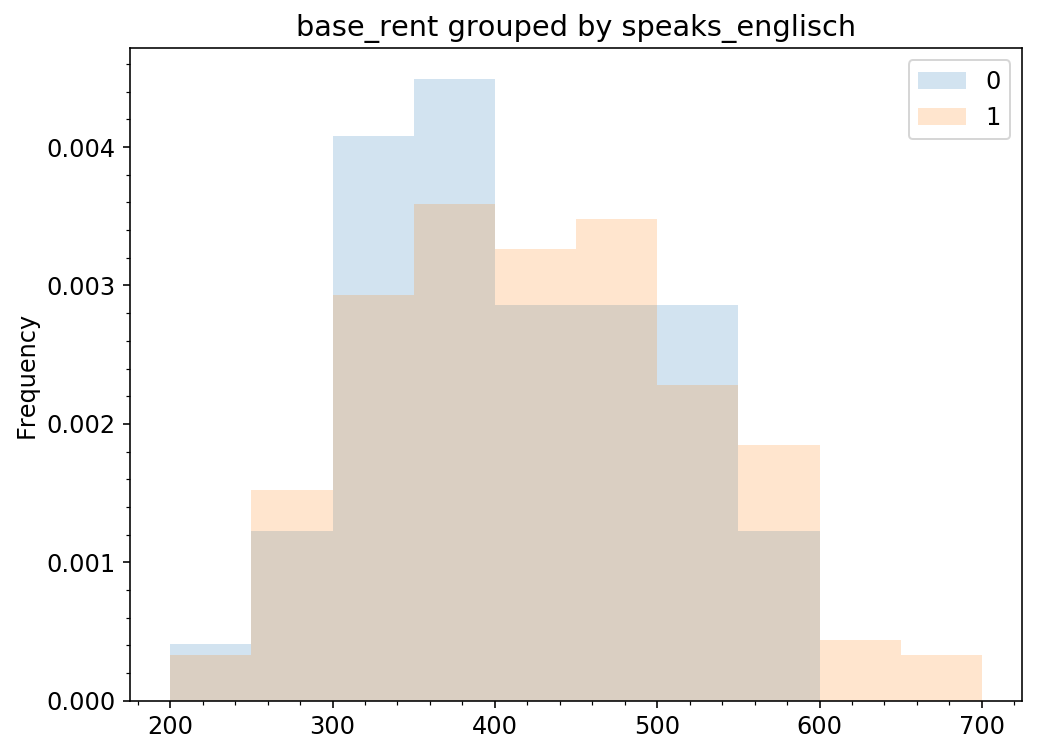

In [173]:
compare_distributions('speaks_englisch', 'base_rent', normed=True, bins=10, range=[200, 700])

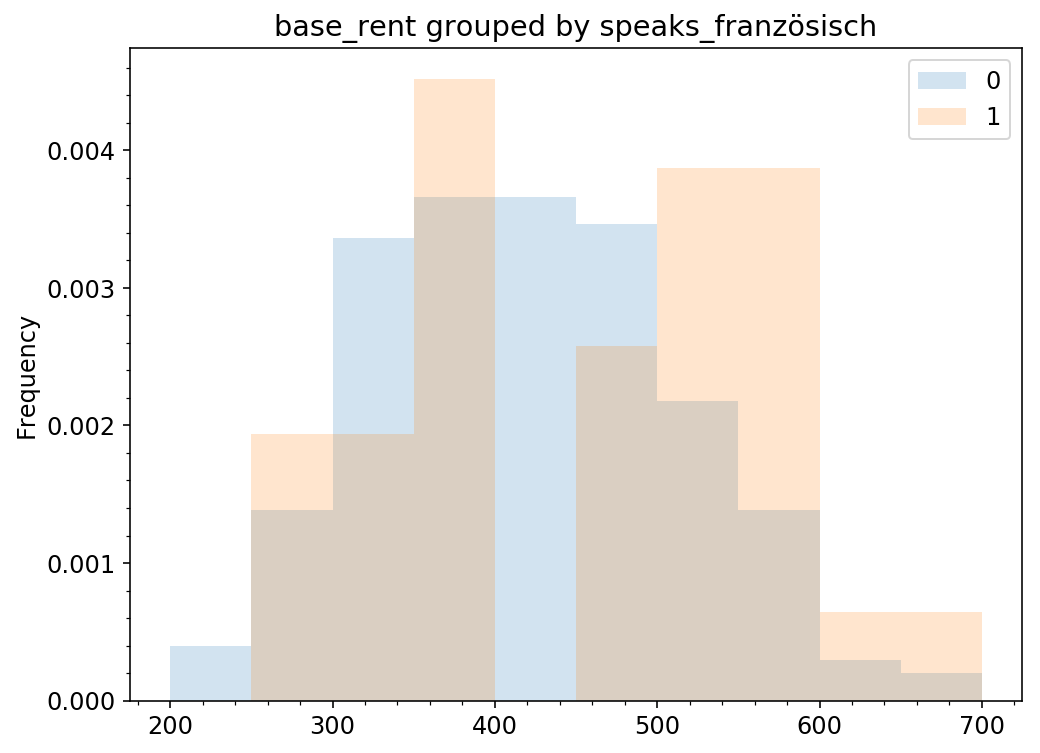

In [174]:
compare_distributions('speaks_französisch', 'base_rent', normed=True, bins=10, range=[200, 700])

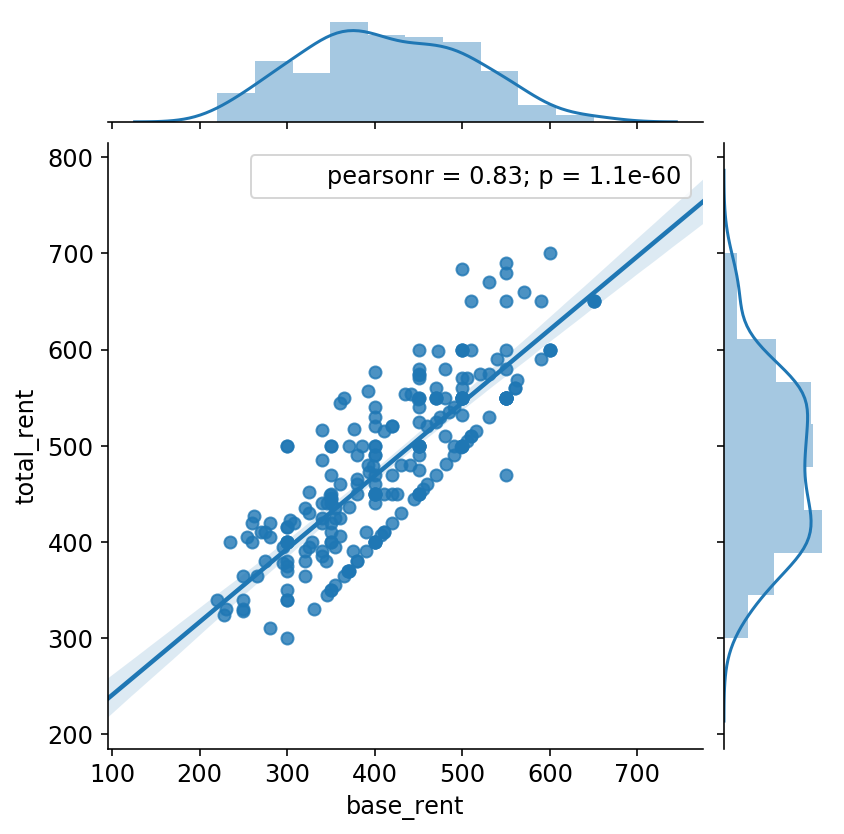

In [175]:
sns.jointplot(x='base_rent', y='total_rent', data=df, kind='reg');
# df.plot.scatter(x='base_rent', y='total_rent');

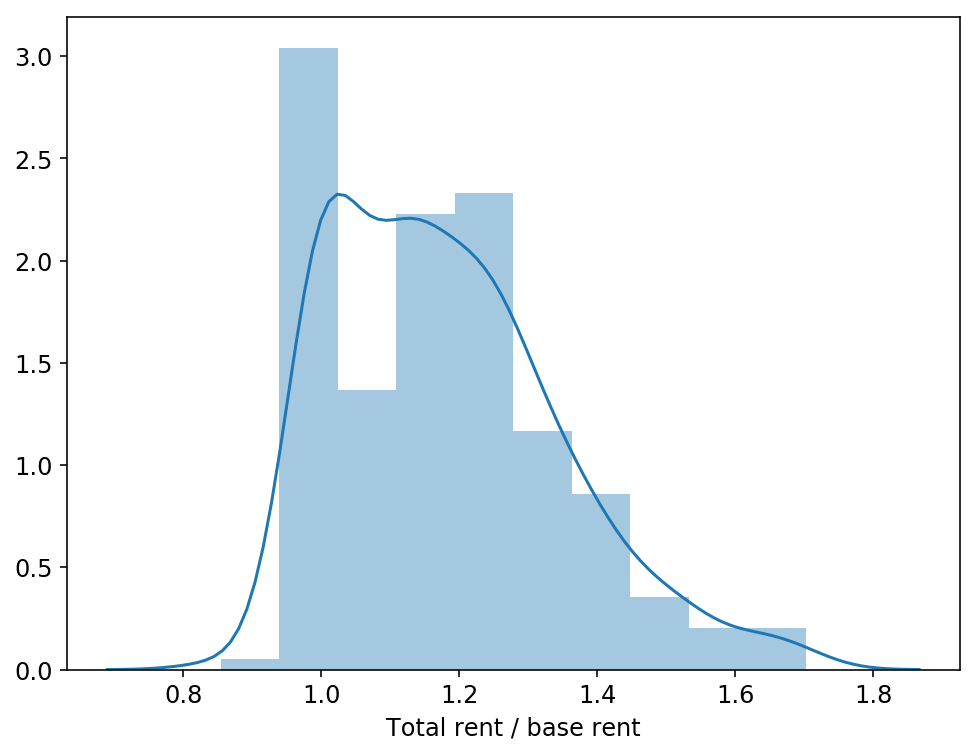

In [176]:
sns.distplot(df.total_rent/df.base_rent);
plt.xlabel("Total rent / base rent");

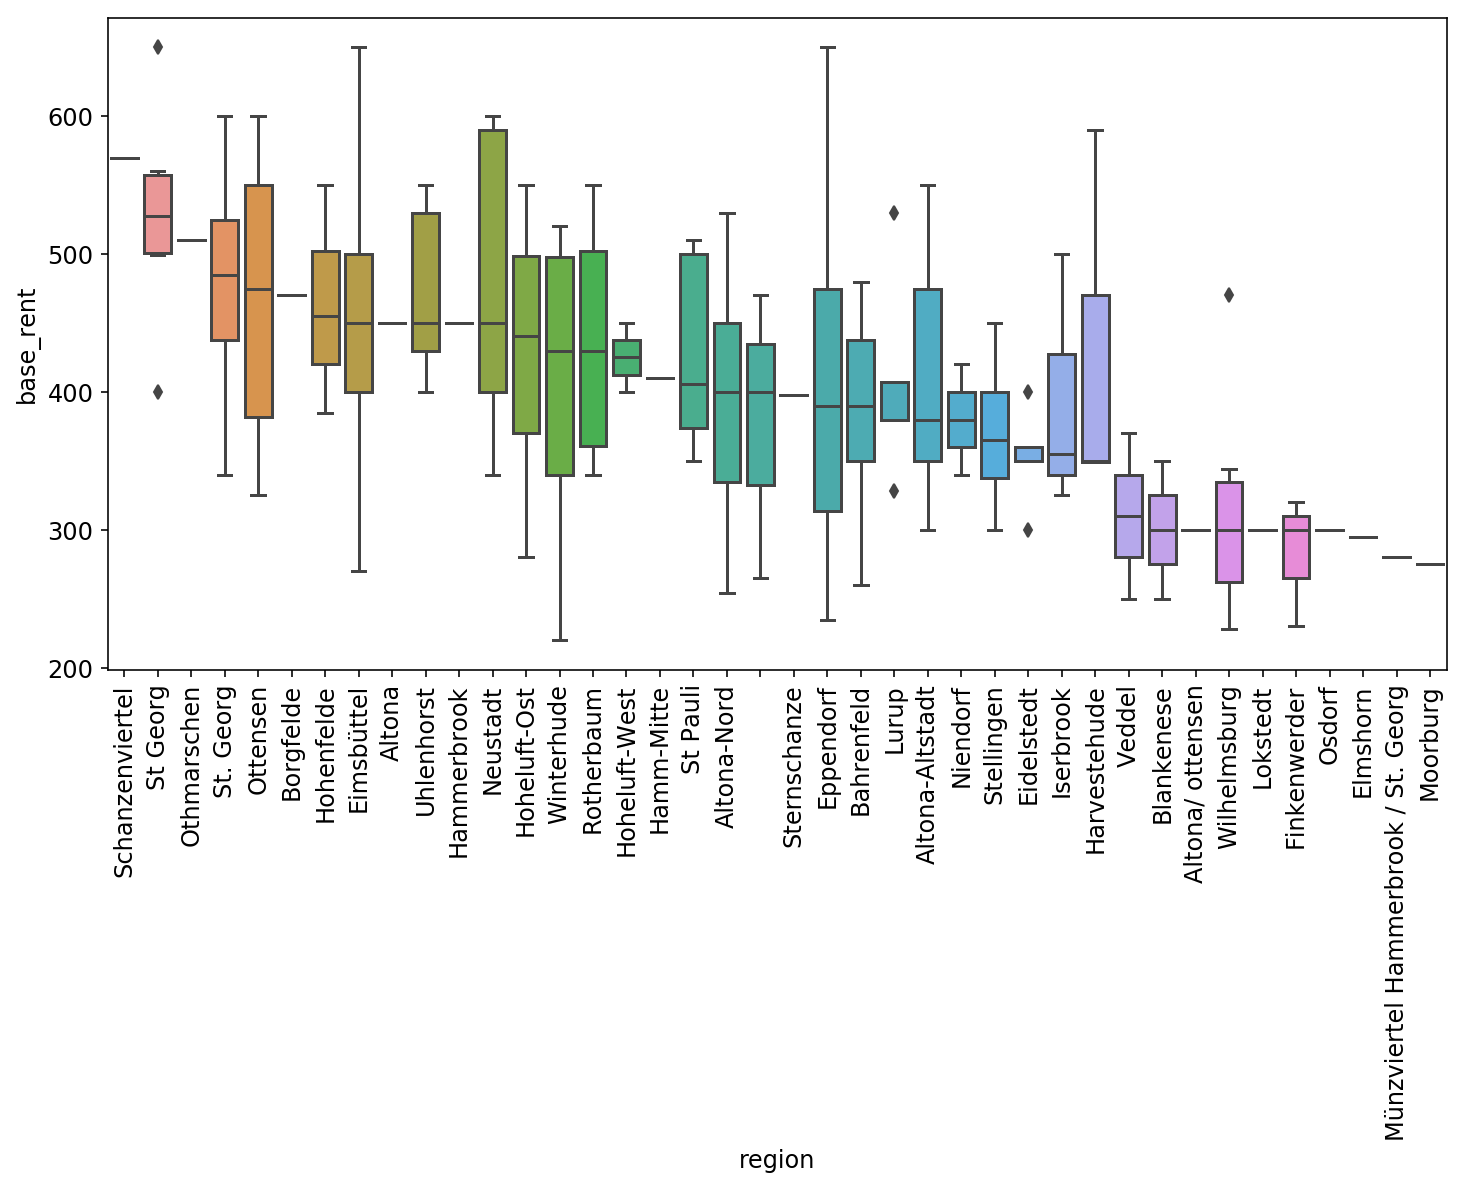

In [178]:
rr = df.groupby('region').base_rent.median().sort_values(ascending=False)
sns.boxplot(y="base_rent", data=df, x="region", order=rr.index);
plt.gcf().set_size_inches(12, 6);
plt.xticks(rotation=90);

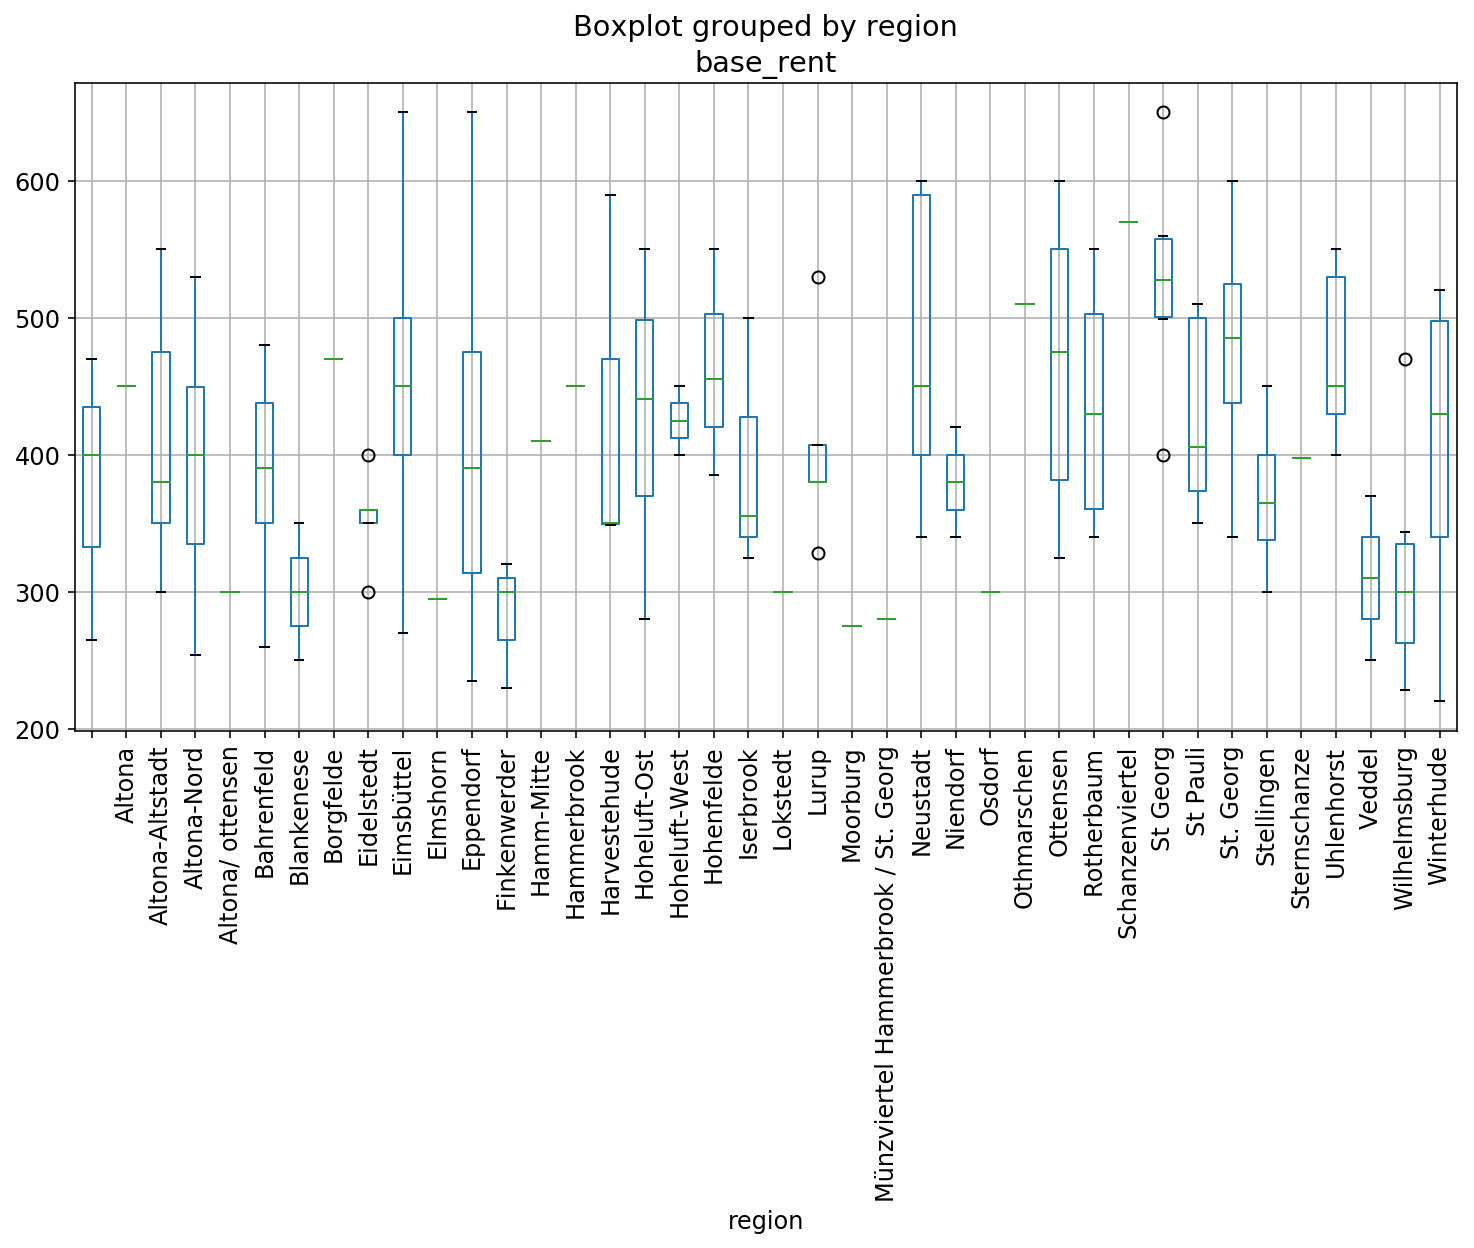

In [179]:
df.boxplot(column='base_rent', by='region', rot=90);
plt.gcf().set_size_inches(12, 6);

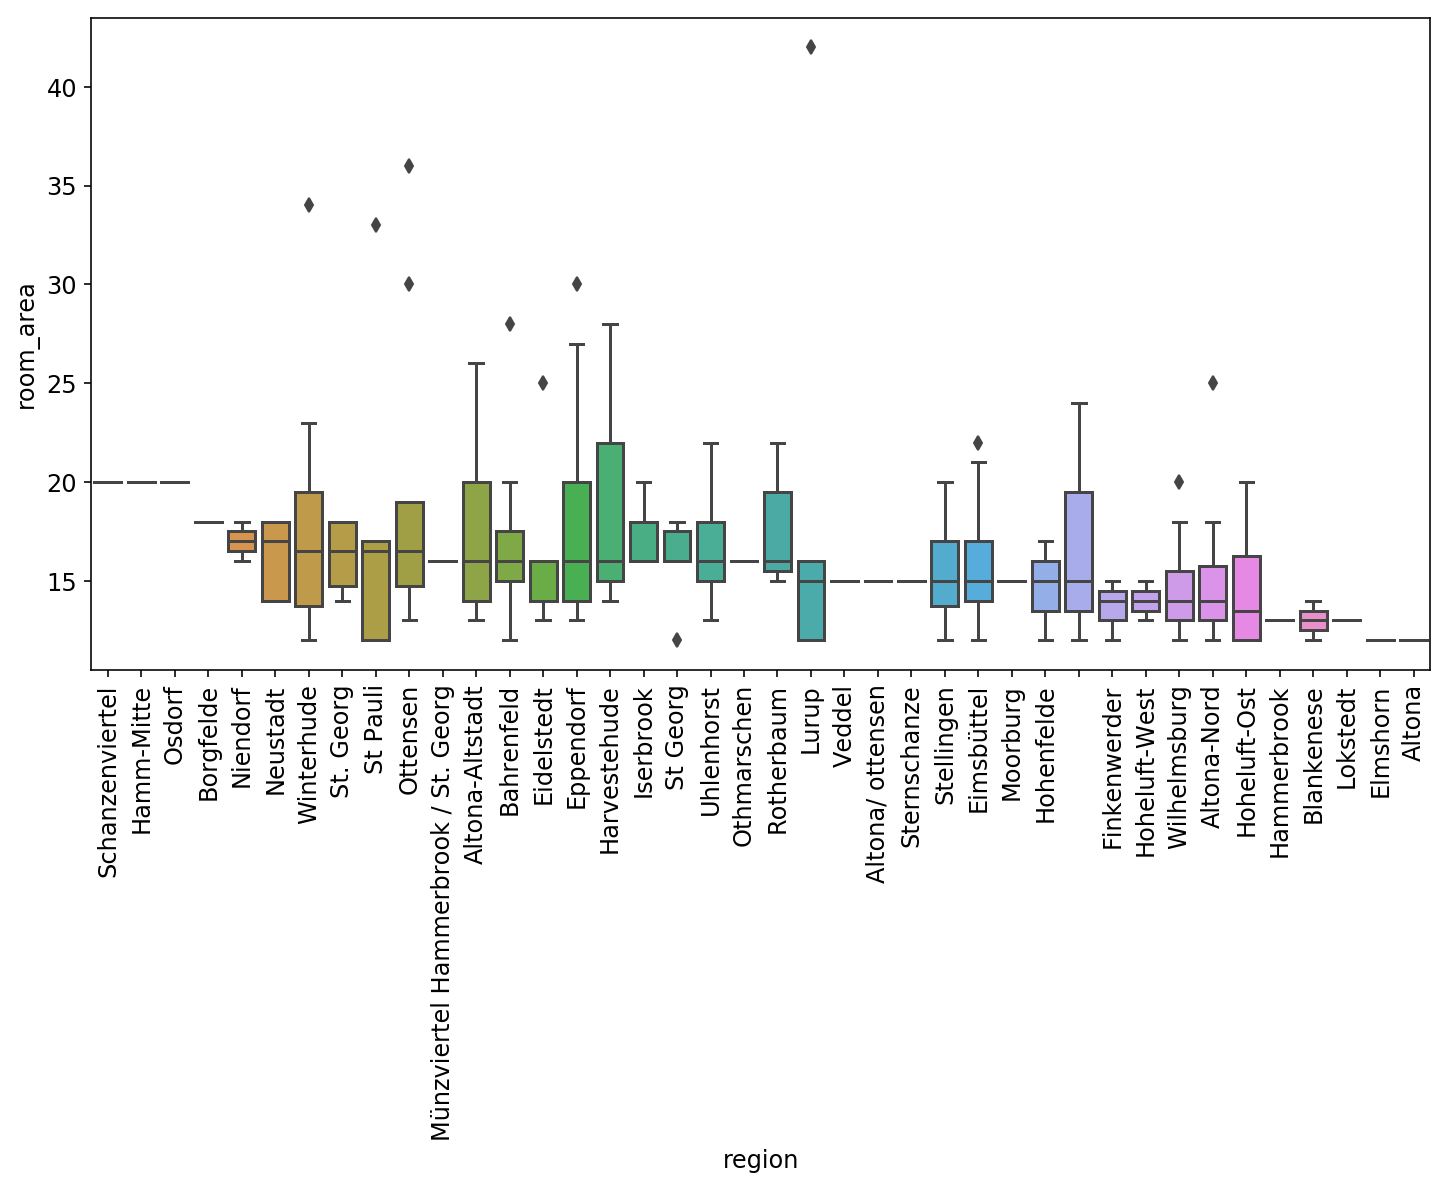

In [180]:
rr = df.groupby('region').room_area.median().sort_values(ascending=False)
sns.boxplot(y="room_area", data=df, x="region", order=rr.index);
plt.gcf().set_size_inches(12, 6);
plt.xticks(rotation=90);

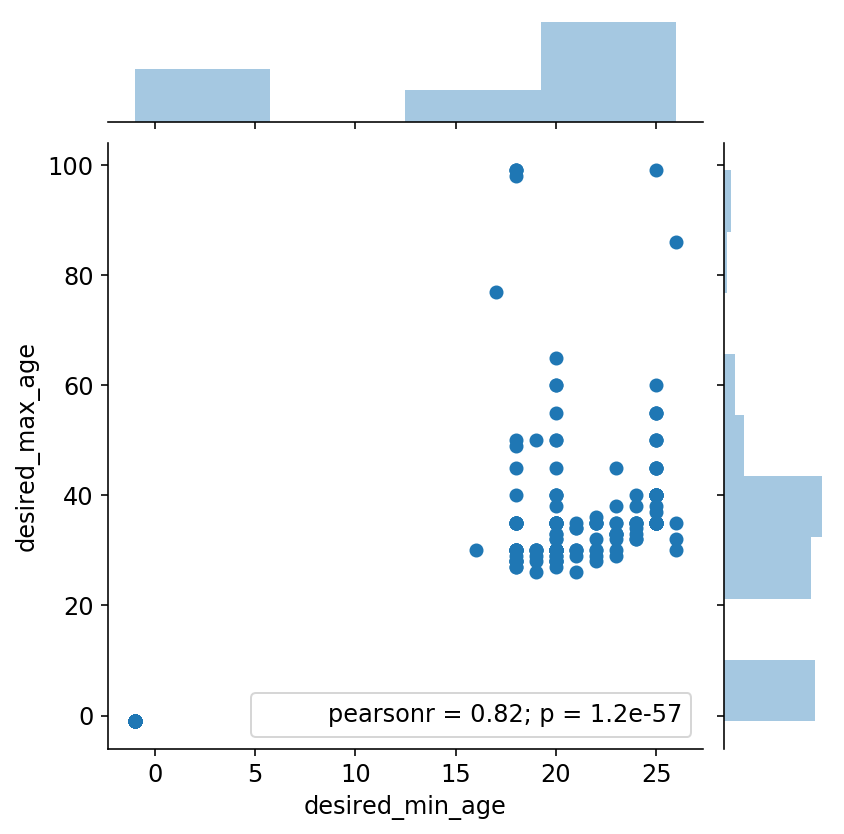

In [181]:
sns.jointplot(x='desired_min_age', y='desired_max_age', data=df);

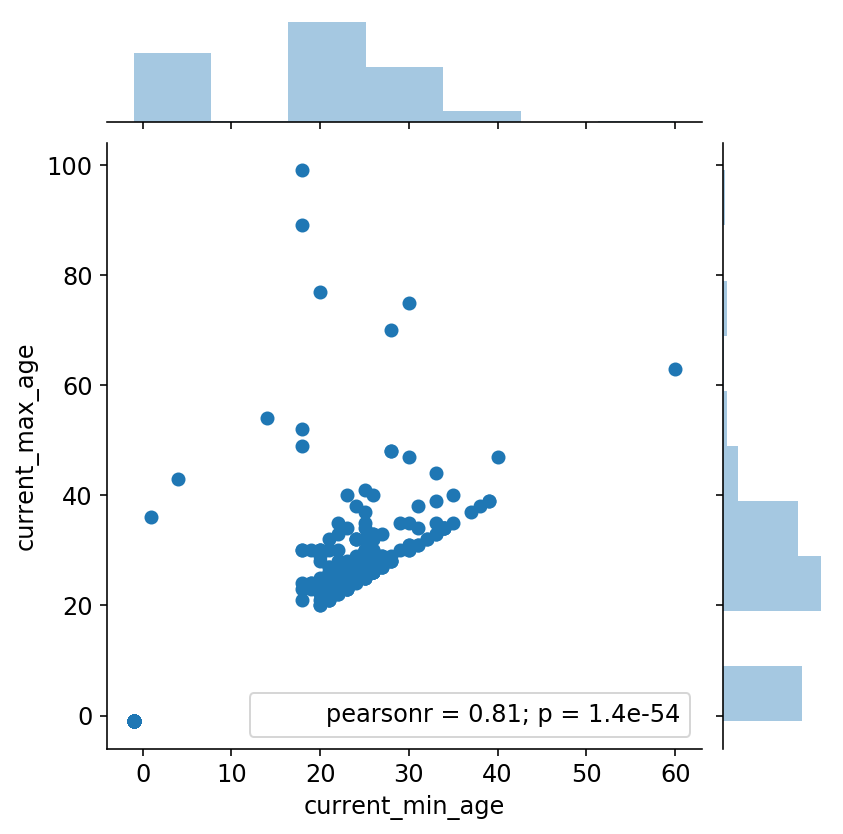

In [182]:
sns.jointplot(x='current_min_age', y='current_max_age', data=df);

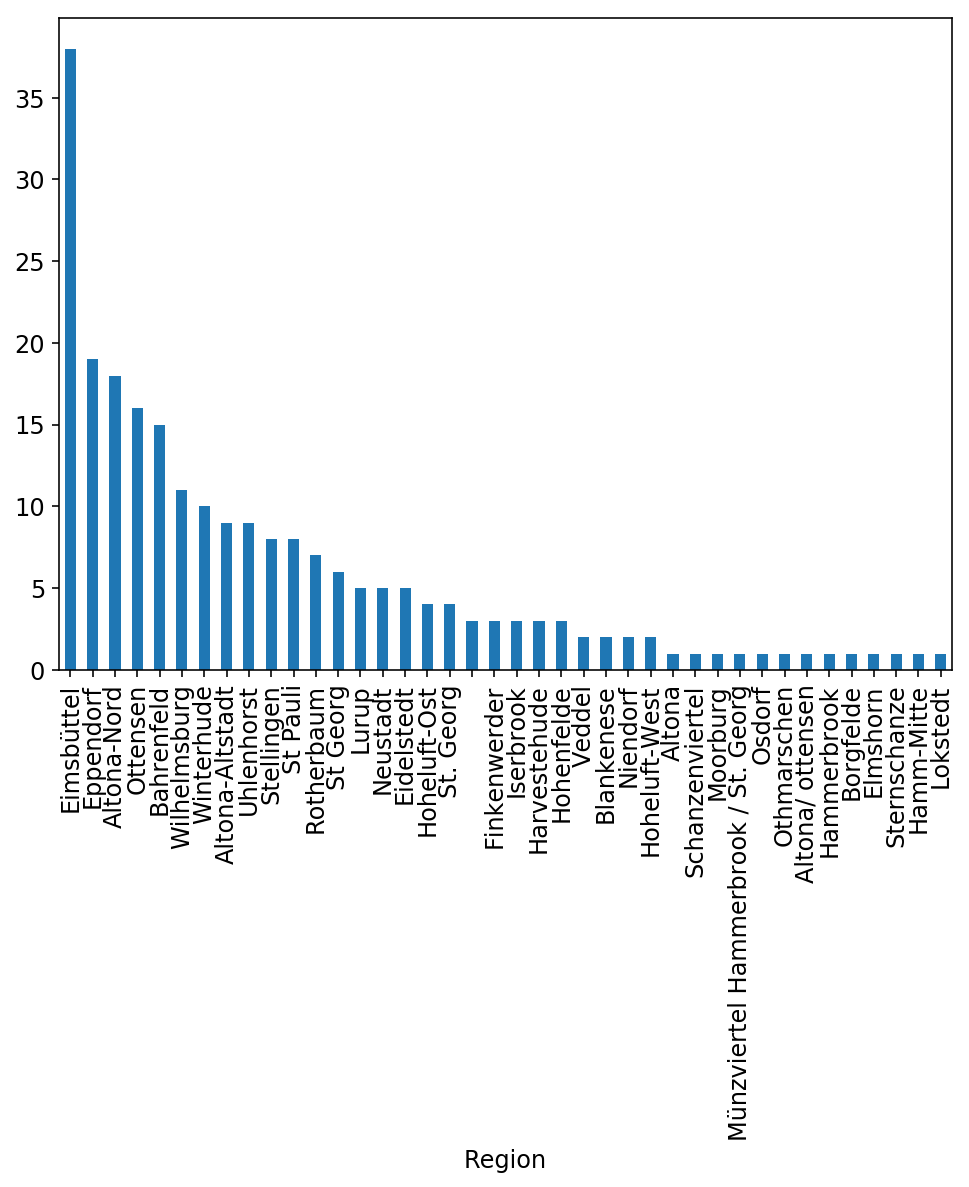

In [183]:
df.region.value_counts().plot(kind='bar');
plt.xlabel("Region");

In [109]:
import gmplot

In [108]:
def pick_color(rent):
    min_col = 

SyntaxError: invalid syntax (<ipython-input-108-a5567e9f0bf8>, line 2)

In [ ]:
gmap = gmplot.GoogleMapPlotter(df.latitude.median(), df.longitude.median(), 12)
# gmap.scatter(df.latitude.values, df.longitude.values, color='red', marker=True)
# gmap.heatmap(df.latitude.values, df.longitude.values, radius=20)
for lat, long, rent in zip(df.latitude.values, df.longitude.values, df.base_rent.values):
    this_col = pick_color(rent)
    gmap.scatter(lat, long, color=this_col, marker=True)